# Data Challenge -- Portfolio Project #1  
### Mohamad Quteifan


# Problem Statement
The journey to employment is not an easy one. We spend our time learning and developing skills to eventually get a job. The research conducted in the following notebook will focus on predicting if a fellow will be placed and the time it will take for a fellow to be placed. Throughout the notebook, I will derive insights around fellows and create two models to effectively predict if and when a fellow will be placed.

That being said, there are two models we are going to create in this case study: 

1. Classification model: Whether or not the fellow will be placed.
2. Regression model: Predict the length that it will take a fellow to find placement. 

The other questions that I will tackle in the research:
1. Overall placement, how many individuals in the program were placed? 
2. Pathrise Placement, did pathrise have an impact?
3. What is the education of the fellows that were placed, did the education impact placement?
4. Duration until placement, how long does it take a fellow to be placed?


### Libraries

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint as pp
from scipy import stats
#!pip install missingno
import warnings
import time
import pickle
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, f1_score, roc_curve, auc, roc_auc_score
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from scipy import stats


warnings.filterwarnings('ignore')
import pip
pip.main(['install', 'xgboost'])
import sys
!{sys.executable} -m pip install xgboost
import xgboost as xgb
import missingno as msno 
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import f1_score, roc_curve, auc, roc_auc_score

from xgboost import XGBClassifier, XGBRegressor

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


# Exploratory Data Analysis

### Import data and review structure/data

In [7]:
df = pd.read_excel("Data_Pathrise.xlsx")

In [8]:
df

,id,pathrise_status,primary_track,cohort_tag,program_duration_days,placed,employment_status,highest_level_of_education,length_of_job_search,biggest_challenge_in_search,professional_experience,work_authorization_status,number_of_interviews,number_of_applications,gender,race
0,1,Active,SWE,OCT19A,NaN,0,Unemployed,Bachelor's Degree,3-5 months,Hearing back on my applications,3-4 years,Canada Citizen,2.0,900,Male,Non-Hispanic White or Euro-American
1,2,Active,PSO,JAN20A,NaN,0,Unemployed,"Some College, No Degree",3-5 months,Getting past final round interviews,1-2 years,Citizen,6.0,0,Male,Non-Hispanic White or Euro-American
2,3,Closed Lost,Design,AUG19B,0.0,0,Employed Part-Time,Master's Degree,Less than one month,Figuring out which jobs to apply for,Less than one year,Citizen,0.0,0,Male,East Asian or Asian American
3,4,Closed Lost,PSO,AUG19B,0.0,0,Contractor,Bachelor's Degree,Less than one month,Getting past final round interviews,Less than one year,Citizen,5.0,25,Male,Decline to Self Identify
4,5,Placed,SWE,AUG19A,89.0,1,Unemployed,Bachelor's Degree,1-2 months,Hearing back on my applications,1-2 years,F1 Visa/OPT,10.0,100,Male,East Asian or Asian American
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2539,2540,Withdrawn (Failed),Design,JUN18A,457.0,0,Contractor,Master's Degree,6 months to a year,Technical interviewing,5+ years,Citizen,4.0,15,Male,Non-Hispanic White or Euro-American
2540,2541,Withdrawn (Failed),Data,JAN19B,488.0,0,NaN,Master's Degree,3-5 months,Hearing back on my applications,1-2 years,F1 Visa/OPT,1.0,7,Male,Non-Hispanic White or Euro-American
2541,2542,Active,SWE,SEP18C,NaN,0,Contractor,Bachelor's Degree,Less than one month,Technical interviewing,1-2 years,Citizen,1.0,30,Female,Non-Hispanic White or Euro-American
2542,2543,Active,SWE,MAY18A,NaN,0,NaN,Master's Degree,Less than one month,Technical interviewing,1-2 years,Citizen,2.0,10,Male,Decline to Self Identify


In [9]:
print("The shape of the data:\n",
      df.shape, 
      "\nThe first 5 rows are:\n", 
      df.head(), 
      "\nThe last 5 rows are:\n",
      df.tail(), 
      "\nThe column names are:\n",
      df.columns)
      


The shape of the data:
 (2544, 16) 
The first 5 rows are:
    id pathrise_status primary_track cohort_tag  program_duration_days  placed  \
0   1          Active           SWE     OCT19A                    NaN       0   
1   2          Active           PSO     JAN20A                    NaN       0   
2   3     Closed Lost        Design     AUG19B                    0.0       0   
3   4     Closed Lost           PSO     AUG19B                    0.0       0   
4   5          Placed           SWE     AUG19A                   89.0       1   

   employment_status  highest_level_of_education length_of_job_search  \
0          Unemployed          Bachelor's Degree           3-5 months   
1          Unemployed    Some College, No Degree           3-5 months   
2  Employed Part-Time            Master's Degree  Less than one month   
3          Contractor          Bachelor's Degree  Less than one month   
4          Unemployed          Bachelor's Degree           1-2 months   

            big

### Variable analysis

In [10]:
print("Pathrise status:\n", df["pathrise_status"].value_counts(),"primary track:\n",
      df["primary_track"].value_counts(),"cohort tag:\n", df["cohort_tag"].value_counts(),
      "program_duration_days:\n", df["program_duration_days"].value_counts().index,
      "placed:\n", df["placed"].value_counts(),
      "Employment Status:\n", df["employment_status "].value_counts(),
      "highest Level of education:\n", df["highest_level_of_education"].value_counts(),
      "Length of the job search:\n", df["length_of_job_search"].value_counts(),
      "Biggest challenge during the job search process:\n", df["biggest_challenge_in_search"].value_counts(),
      "Professional Experience:\n", df["professional_experience"].value_counts(),
      "Work authorization status (citizenship):\n", df["work_authorization_status"].value_counts(),
      "The number of interviews:\n", df["number_of_interviews"].value_counts(),
      "number_of_applications:\n", df["number_of_applications"].value_counts(),
      "gender:\n", df["gender"].value_counts(),
      "race:\n", df["race"].value_counts()
         
     )

Pathrise status:
 Placed                956
Active                532
Withdrawn             398
Withdrawn (Trial)     276
Closed Lost           182
Withdrawn (Failed)     82
MIA                    52
Deferred               34
Break                  32
Name: pathrise_status, dtype: int64 primary track:
 SWE          1678
PSO           322
Design        288
Data          248
Web             6
Marketing       2
Name: primary_track, dtype: int64 cohort tag:
 JAN19A    132
JAN20A    124
DEC18A    116
FEB20A    108
AUG19C     88
OCT18B     84
OCT18A     82
AUG19B     82
JAN20B     82
JAN19B     74
MAR19A     74
OCT19A     68
JUL19A     66
SEP19B     66
DEC19A     64
FEB19A     64
JUN19B     64
NOV19A     62
NOV18A     62
AUG19A     60
SEP19A     60
JUN19A     54
SEP18C     54
OCT19B     54
AUG18A     50
SEP18B     50
JUN18A     48
SEP18A     48
APR19A     48
JUL19B     44
MAR19B     44
FEB19B     42
NOV19B     40
APR19B     34
MAY18A     32
FEB18A     30
APR18B     30
MAR18A     30
FEB20B   

### Quick Analysis on the Review of the data

The data file imported contains 2544 rows and 16 columns. The columns of the data are: 

#1. id: the identification of the individual, each id represents an individual. It consists of numeric values starting with 1. 

#2. pathrise_status: The variable represent the pathrise status of the individual. It is a text variable (values consists of textual data) and there are 9 different values.

#3. primary_track: The variable represents the individuals career path/track. It is a text variable (values consists of textual data) and there are 6 different values.

#4. cohort_tag: The variable represents the class(cohort) the individual joined. It is a datetime variable, consists of text and numeric values. The variable will unlikily be used when modeling. The variable contains 47 different values. 

#5. program_duration_days: The length that the individual was part of the program. It consists of numeric values. There are a total of 411 different values. 

#6. placed: The variable represents if the individual was successfully placed in a position. It consists of numeric values and there are 2 different values. 0 = not placed 1 = placed. 

#7. employment_status: The variable represents the employement status of the individual prior to joining pathrise. It consists of text data and there are 5 different values. The variable contains a space in the column and that needs to be corrected.

#8. highest_level_of_education: The variable represents the education of the individual prior to joining pathrise. It consists of text data and there are 7 different values. This will be used in the model more than likily.

#9. length_of_job_search: The variable represents the length of the job search of the individual. It consists of text data and there are 5 different values. 

#10. biggest_challenge_in_search: The variable represents the biggest challenge the individual had prior to joining pathrise. It consists of text data and there are 10 different values. 

#11. professional_experience: The variable represents the professional experience of the individual prior to joining pathrise. It consists of text data and there are 4 different values.

#12. work_authorization_status: The variable represents the work authorization status(citizenship/authorization). It consists of text data and there are 9 different values. 

#13. number_of_interviews: The variable represents the number of interviews an individual had prior to joining pathrise. It consists of numeric values and there are 21 values.

#14. number_of_applications: The vairable represents the number of applciations that the individual filled prior to joining pathrise. It consists of numerical values and there are 41 different values. 

#15. gender: The variable represents the gender(sex) of the individual. It consist of text data and there are 4 different values.  

#16. race: The variables represents the race of the individual. It consists of text data and there are 9 different values. 

In [11]:
df

,id,pathrise_status,primary_track,cohort_tag,program_duration_days,placed,employment_status,highest_level_of_education,length_of_job_search,biggest_challenge_in_search,professional_experience,work_authorization_status,number_of_interviews,number_of_applications,gender,race
0,1,Active,SWE,OCT19A,NaN,0,Unemployed,Bachelor's Degree,3-5 months,Hearing back on my applications,3-4 years,Canada Citizen,2.0,900,Male,Non-Hispanic White or Euro-American
1,2,Active,PSO,JAN20A,NaN,0,Unemployed,"Some College, No Degree",3-5 months,Getting past final round interviews,1-2 years,Citizen,6.0,0,Male,Non-Hispanic White or Euro-American
2,3,Closed Lost,Design,AUG19B,0.0,0,Employed Part-Time,Master's Degree,Less than one month,Figuring out which jobs to apply for,Less than one year,Citizen,0.0,0,Male,East Asian or Asian American
3,4,Closed Lost,PSO,AUG19B,0.0,0,Contractor,Bachelor's Degree,Less than one month,Getting past final round interviews,Less than one year,Citizen,5.0,25,Male,Decline to Self Identify
4,5,Placed,SWE,AUG19A,89.0,1,Unemployed,Bachelor's Degree,1-2 months,Hearing back on my applications,1-2 years,F1 Visa/OPT,10.0,100,Male,East Asian or Asian American
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2539,2540,Withdrawn (Failed),Design,JUN18A,457.0,0,Contractor,Master's Degree,6 months to a year,Technical interviewing,5+ years,Citizen,4.0,15,Male,Non-Hispanic White or Euro-American
2540,2541,Withdrawn (Failed),Data,JAN19B,488.0,0,NaN,Master's Degree,3-5 months,Hearing back on my applications,1-2 years,F1 Visa/OPT,1.0,7,Male,Non-Hispanic White or Euro-American
2541,2542,Active,SWE,SEP18C,NaN,0,Contractor,Bachelor's Degree,Less than one month,Technical interviewing,1-2 years,Citizen,1.0,30,Female,Non-Hispanic White or Euro-American
2542,2543,Active,SWE,MAY18A,NaN,0,NaN,Master's Degree,Less than one month,Technical interviewing,1-2 years,Citizen,2.0,10,Male,Decline to Self Identify


## Placement Analysis

### Part 1: Overall placement, how many individuals in the program were placed? 

In [12]:
placed = df["placed"]

placed= placed.replace([0],"not_placed")
placed = placed.replace([1],"placed")


#Check if there are any missing values within the variable
print("Are there any NaN or empty values in the column?", placed.isnull().values.any(), "\nThere are: ",
placed.isnull().values.sum(), "in the column")

placed

Are there any NaN or empty values in the column? False 
There are:  0 in the column


0       not_placed
1       not_placed
2       not_placed
3       not_placed
4           placed
           ...    
2539    not_placed
2540    not_placed
2541    not_placed
2542    not_placed
2543    not_placed
Name: placed, Length: 2544, dtype: object

The good thing about the column "placed" is that there are no NaN or empty values. This is not the case for the majority of the data frame, but that will be looked at in the following steps. The purpose of this portion of the research is to calculate the percentage of individuals getting placed. I am converting the numeric values into text values for readability, easier to review visual when its placed vs. not_placed compared to 1 vs. 0.  

### Visualize the distribution of placement

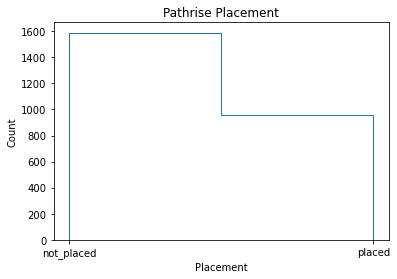

In [13]:
plt.hist(placed, bins=2, histtype='step')
# Label the axes
plt.xlabel('Placement')
plt.ylabel('Count')
plt.title('Pathrise Placement')
# Show the figure
plt.show()


In [14]:
plt.savefig('place_fig11.PDF') #save plot to desktop for research paper.

<Figure size 432x288 with 0 Axes>

Statistics

In [15]:
print(placed.value_counts())
placements = 956
not_placed = 1588
total_individuals = 2544

print("Out of all the individuals included in the data,",((placements/total_individuals)*100),"% were placed.")


not_placed    1588
placed         956
Name: placed, dtype: int64
Out of all the individuals included in the data, 37.57861635220126 % were placed.


### Quick placement analysis 
Taking a glance at the distribution(histogram) we can see that more individuals were not placed. This information may be misleading since many individuals withdraw from the program or did not participate in the program. We can conclude that approximately 37.6% of individuals were placed based on this information. In the following steps, we will look deeper into the difference between Pathrise individuals who did not withdraw from the program. The focus will be to determine if Pathrise had an impact on placement. 

### Part 2: Pathrise Placement, did pathrise have an impact? 

The important part is isolating the individuals who did not withdraw from the program and to analyze the success rate of Pathrise fellows.

In [16]:
df["pathrise_status"].value_counts()

Placed                956
Active                532
Withdrawn             398
Withdrawn (Trial)     276
Closed Lost           182
Withdrawn (Failed)     82
MIA                    52
Deferred               34
Break                  32
Name: pathrise_status, dtype: int64

#### Placed and active are considered part of the pathrise program, withdrawn, withdrawn (Trail), MIA, Deferred, and break are all individuals who did not participate in the program and are not considered fellows. Closed Lost are the individuals who went through the program and did not gain placement. 

In [17]:
path = df["pathrise_status"]
print("Are there any NaN or empty values in the column?",path.isnull().values.any(), "\nThere are: ",
path.isnull().values.sum(), "in the column")

Are there any NaN or empty values in the column? False 
There are:  0 in the column


There are no empty values in Pathrise_status column.

In [18]:
path = path.replace([["Withdrawn", "Withdrawn (Trial)", "MIA", "Deferred"]],"not_enrolled")
path = path.replace([["Placed", "Withdrawn (Failed)", "Active", "Closed Lost", "Break"]],"enrolled")

path.value_counts()

enrolled        1784
not_enrolled     760
Name: pathrise_status, dtype: int64

#### Quick visual: histogram of the enrolled vs not enrolled individuals

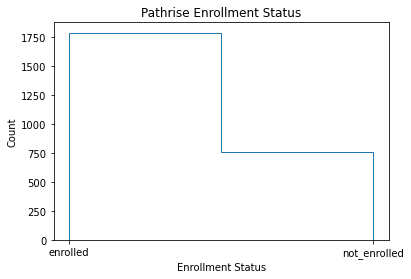

In [19]:
plt.hist(path, bins=2, histtype='step')
# Label the axes
plt.xlabel('Enrollment Status')
plt.ylabel('Count')
plt.title('Pathrise Enrollment Status')
# Show the figure
plt.show()

##### Now import the changes made to both pathrise status and placed back into the main dataframe

In [20]:
df["placed"] = placed
df["pathrise_status"] = path


### Clean Data, Missing Values

In [21]:
print("Are there any NaN or empty values in the dateframe?", df.isnull().values.any(), "\n",
df.isnull().sum() >0)


Are there any NaN or empty values in the dateframe? True 
 id                             False
pathrise_status                False
primary_track                  False
cohort_tag                      True
program_duration_days           True
placed                         False
employment_status               True
highest_level_of_education      True
length_of_job_search            True
biggest_challenge_in_search     True
professional_experience         True
work_authorization_status       True
number_of_interviews            True
number_of_applications         False
gender                          True
race                            True
dtype: bool


##### Empty values
In the dataframe, all but 5 columns contain empty/NaN values. 

In [22]:
print("There are: ", df["cohort_tag"].isnull().values.sum(), " in the cohort_tag column",
      "\nThere are: ", df["program_duration_days"].isnull().values.sum(), "in the program_duration_days column",
      "\nThere are: ", df["employment_status "].isnull().values.sum(), "in the employment_status column",
      "\nThere are: ", df["highest_level_of_education"].isnull().values.sum(), "in the highest_level_of_education column",
      "\nThere are: ", df["length_of_job_search"].isnull().values.sum(), "in the length_of_job_search column",
      "\nThere are: ", df["biggest_challenge_in_search"].isnull().values.sum(), "in the column",
      "\nThere are: ", df["professional_experience"].isnull().values.sum(), "in the professional_experience column",
      "\nThere are: ", df["work_authorization_status"].isnull().values.sum(), "in the work_authorization_status column",
      "\nThere are: ", df["number_of_interviews"].isnull().values.sum(), "in the number_of_interviews column",
      "\nThere are: ", df["gender"].isnull().values.sum(), "in the gender column",
      "\nThere are: ", df["race"].isnull().values.sum(), "in the race column"
     )

There are:  8  in the cohort_tag column 
There are:  616 in the program_duration_days column 
There are:  229 in the employment_status column 
There are:  58 in the highest_level_of_education column 
There are:  74 in the length_of_job_search column 
There are:  24 in the column 
There are:  222 in the professional_experience column 
There are:  284 in the work_authorization_status column 
There are:  218 in the number_of_interviews column 
There are:  492 in the gender column 
There are:  18 in the race column


##### Visual of missing values

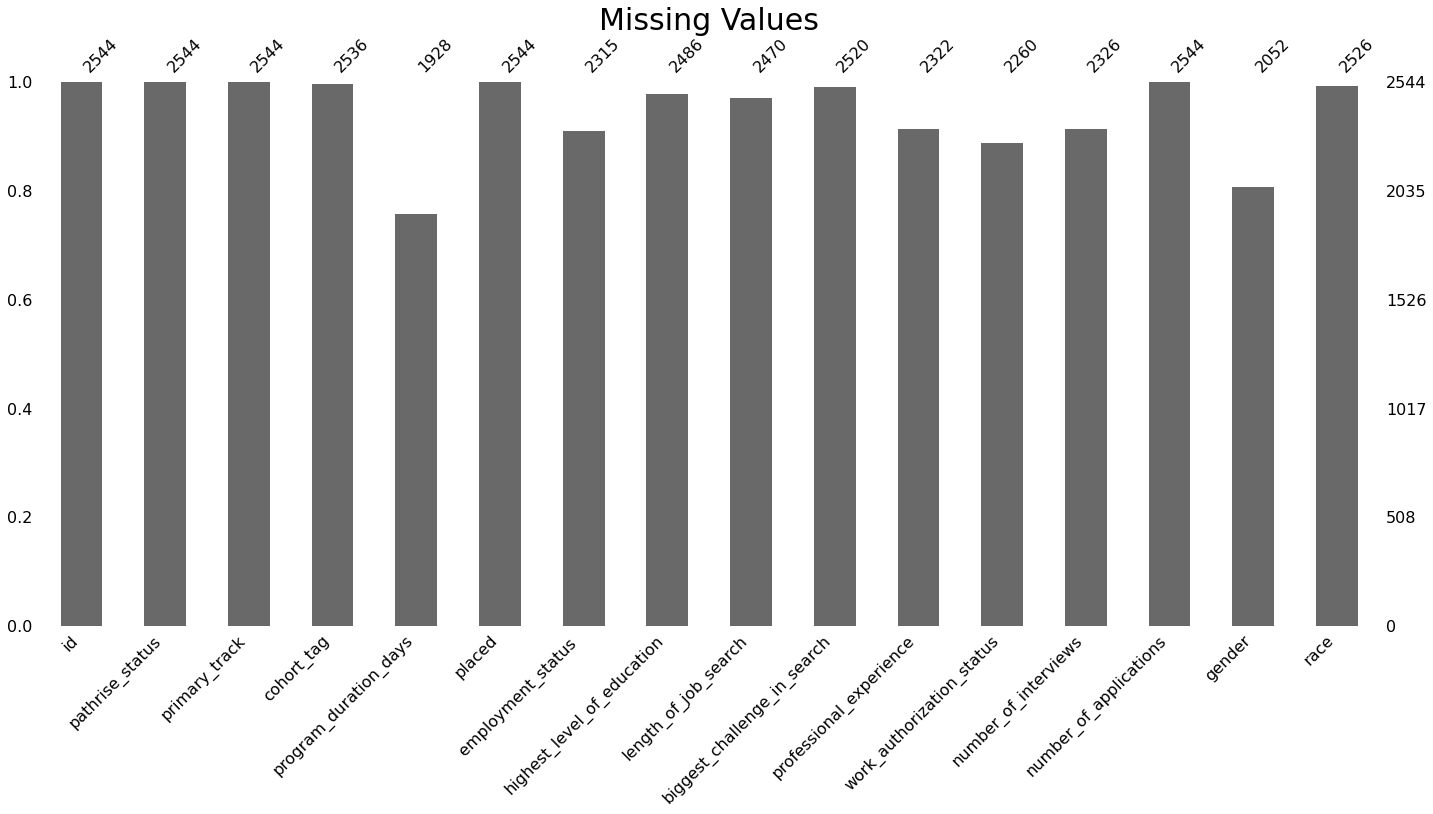

In [23]:
msno.bar(df)
#plt.figure(figsize=(10,10))
#plt.xlabel('Columns', fontsize = 30 )
#plt.ylabel('Values')
plt.title('Missing Values', fontsize = 30)
# Show the figure
plt.show()


Reducing the the values into 2 different values rather than 9 will give us a better understanding of how successful the program is for the people that acutally participated in the program. There were 1784 participates that were involved in the program 

### 

# Education impact, did individuals who had a formal education or higher education placed at a higher rate compared to other individuals? 

### Part 1: What is the education of the fellows that were placed 

In [24]:
#First rename highest level of education to make it easier in the future
df = df.rename(columns={'highest_level_of_education': 'education', 'program_duration_days': "days_program"})

edu = df["education"]
edu_b = edu == "Bachelor's Degree"
edu_m = edu == "Master's Degree"
edu_scollege = edu == "Some College, No Degree"
edu_d = edu == "Doctorate or Professional Degree"
edu_hdrop = edu == "Some High School"
edu_hs = edu == "High School Graduate"
edu_ged = edu == "GED or equivalent"


In [25]:
edu_b_placement = edu_b[df["placed"]=="placed"]
edu_m_placement = edu_m[df["placed"]=="placed"]
edu_scollege_placement = edu_scollege[df["placed"]=="placed"]
edu_d_placement = edu_d[df["placed"]=="placed"]
edu_hdrop_placement = edu_hdrop[df["placed"]=="placed"]
edu_hs_placement = edu_hs[df["placed"]=="placed"]
edu_ged_placement = edu_ged[df["placed"]=="placed"]


print("There were",edu_b_placement.values.sum(), "fellows with Bachelor's Degrees that got placed",
     "\nThere were",edu_m_placement.values.sum(), "fellows with Master's Degrees that got placed",
      "\nThere were",edu_d_placement.values.sum(), "fellows with Doctorate or Professional Degree that got placed",
      "\nThere were",edu_scollege_placement.values.sum(), "fellows with Some College, No Degree that got placed",
      "\nThere were",edu_hdrop_placement.values.sum(), "fellows without a Highschool Degree that got placed",
      "\nThere were",edu_hs_placement.values.sum(), "fellows with a Highschool Degree that got placed",
      "\nThere were",edu_ged_placement.values.sum(), "fellows that recieved their highschool GED that got placed")


There were 524 fellows with Bachelor's Degrees that got placed 
There were 288 fellows with Master's Degrees that got placed 
There were 59 fellows with Doctorate or Professional Degree that got placed 
There were 50 fellows with Some College, No Degree that got placed 
There were 4 fellows without a Highschool Degree that got placed 
There were 10 fellows with a Highschool Degree that got placed 
There were 5 fellows that recieved their highschool GED that got placed


In [26]:
print((edu_b_placement.values.sum()/edu_b_placement.value_counts().sum())* 100, "%of the fellows who got placed had a Bachelor's Degree")
print((edu_m_placement.values.sum()/edu_m_placement.value_counts().sum())* 100, "%of the fellows who got placed had a Master's Degree")
print((edu_d_placement.values.sum()/edu_d_placement.value_counts().sum())* 100, "%of the fellows who got placed had a Doctorate or Professional Degree")
print((edu_scollege_placement.values.sum()/edu_scollege_placement.value_counts().sum())* 100, "%of the fellows who got placed had a some college education but did not recieve a degree")
print((edu_hdrop_placement.values.sum()/edu_hdrop_placement.value_counts().sum())* 100, "%of the fellows who got placed did not recieve a highschool high school diploma")
print((edu_hs_placement.values.sum()/edu_hs_placement.value_counts().sum())* 100, "%of the fellows who got placed recieved a highschool diploma")
print((edu_ged_placement.values.sum()/edu_ged_placement.value_counts().sum())* 100, "%of the fellows who got placed recieved their highschool GED")

      
      
      

54.811715481171554 %of the fellows who got placed had a Bachelor's Degree
30.125523012552303 %of the fellows who got placed had a Master's Degree
6.171548117154812 %of the fellows who got placed had a Doctorate or Professional Degree
5.230125523012552 %of the fellows who got placed had a some college education but did not recieve a degree
0.41841004184100417 %of the fellows who got placed did not recieve a highschool high school diploma
1.0460251046025104 %of the fellows who got placed recieved a highschool diploma
0.5230125523012552 %of the fellows who got placed recieved their highschool GED


### Part 2: Education of fellows that were enrolled in the program, place and not placed and analysis 

Step 1: Remove the individuals who did not enroll in the program(withdrew) or went MIA
NOTE: I did not remove empty values just yet, but I will be removing them shortly


In [27]:
#Make a quick copy of the dataframe
df_copy = df.copy()
df_copy

,id,pathrise_status,primary_track,cohort_tag,days_program,placed,employment_status,education,length_of_job_search,biggest_challenge_in_search,professional_experience,work_authorization_status,number_of_interviews,number_of_applications,gender,race
0,1,enrolled,SWE,OCT19A,NaN,not_placed,Unemployed,Bachelor's Degree,3-5 months,Hearing back on my applications,3-4 years,Canada Citizen,2.0,900,Male,Non-Hispanic White or Euro-American
1,2,enrolled,PSO,JAN20A,NaN,not_placed,Unemployed,"Some College, No Degree",3-5 months,Getting past final round interviews,1-2 years,Citizen,6.0,0,Male,Non-Hispanic White or Euro-American
2,3,enrolled,Design,AUG19B,0.0,not_placed,Employed Part-Time,Master's Degree,Less than one month,Figuring out which jobs to apply for,Less than one year,Citizen,0.0,0,Male,East Asian or Asian American
3,4,enrolled,PSO,AUG19B,0.0,not_placed,Contractor,Bachelor's Degree,Less than one month,Getting past final round interviews,Less than one year,Citizen,5.0,25,Male,Decline to Self Identify
4,5,enrolled,SWE,AUG19A,89.0,placed,Unemployed,Bachelor's Degree,1-2 months,Hearing back on my applications,1-2 years,F1 Visa/OPT,10.0,100,Male,East Asian or Asian American
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2539,2540,enrolled,Design,JUN18A,457.0,not_placed,Contractor,Master's Degree,6 months to a year,Technical interviewing,5+ years,Citizen,4.0,15,Male,Non-Hispanic White or Euro-American
2540,2541,enrolled,Data,JAN19B,488.0,not_placed,NaN,Master's Degree,3-5 months,Hearing back on my applications,1-2 years,F1 Visa/OPT,1.0,7,Male,Non-Hispanic White or Euro-American
2541,2542,enrolled,SWE,SEP18C,NaN,not_placed,Contractor,Bachelor's Degree,Less than one month,Technical interviewing,1-2 years,Citizen,1.0,30,Female,Non-Hispanic White or Euro-American
2542,2543,enrolled,SWE,MAY18A,NaN,not_placed,NaN,Master's Degree,Less than one month,Technical interviewing,1-2 years,Citizen,2.0,10,Male,Decline to Self Identify


In [28]:
#Removign all the 
df_copy = df_copy[df_copy.pathrise_status != "not_enrolled"]


In [29]:
df_copy
#There were a total of 1784 fellows who enrolled in the program.

,id,pathrise_status,primary_track,cohort_tag,days_program,placed,employment_status,education,length_of_job_search,biggest_challenge_in_search,professional_experience,work_authorization_status,number_of_interviews,number_of_applications,gender,race
0,1,enrolled,SWE,OCT19A,NaN,not_placed,Unemployed,Bachelor's Degree,3-5 months,Hearing back on my applications,3-4 years,Canada Citizen,2.0,900,Male,Non-Hispanic White or Euro-American
1,2,enrolled,PSO,JAN20A,NaN,not_placed,Unemployed,"Some College, No Degree",3-5 months,Getting past final round interviews,1-2 years,Citizen,6.0,0,Male,Non-Hispanic White or Euro-American
2,3,enrolled,Design,AUG19B,0.0,not_placed,Employed Part-Time,Master's Degree,Less than one month,Figuring out which jobs to apply for,Less than one year,Citizen,0.0,0,Male,East Asian or Asian American
3,4,enrolled,PSO,AUG19B,0.0,not_placed,Contractor,Bachelor's Degree,Less than one month,Getting past final round interviews,Less than one year,Citizen,5.0,25,Male,Decline to Self Identify
4,5,enrolled,SWE,AUG19A,89.0,placed,Unemployed,Bachelor's Degree,1-2 months,Hearing back on my applications,1-2 years,F1 Visa/OPT,10.0,100,Male,East Asian or Asian American
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2537,2538,enrolled,SWE,JAN19B,NaN,not_placed,Contractor,Bachelor's Degree,1-2 months,Getting past final round interviews,1-2 years,NaN,1.0,70,Male,Non-Hispanic White or Euro-American
2539,2540,enrolled,Design,JUN18A,457.0,not_placed,Contractor,Master's Degree,6 months to a year,Technical interviewing,5+ years,Citizen,4.0,15,Male,Non-Hispanic White or Euro-American
2540,2541,enrolled,Data,JAN19B,488.0,not_placed,NaN,Master's Degree,3-5 months,Hearing back on my applications,1-2 years,F1 Visa/OPT,1.0,7,Male,Non-Hispanic White or Euro-American
2541,2542,enrolled,SWE,SEP18C,NaN,not_placed,Contractor,Bachelor's Degree,Less than one month,Technical interviewing,1-2 years,Citizen,1.0,30,Female,Non-Hispanic White or Euro-American


In [30]:
#Check empty values before moving forward
print(df_copy['pathrise_status'].isnull().sum())
print(df_copy['placed'].isnull().sum())
print(df_copy['education'].isnull().sum())


0
0
39


### Removing of missing values in Education
Removing the missing values now may effect the duration analysis later on but it needs to be removed now to conduct the education and placement analysis.

In [31]:
#I will be removing the empty values from education
print(df_copy.shape)
df_copy.dropna(subset=['education'], inplace=True)
print(df_copy.shape[0])

(1784, 16)
1745


In [32]:
##Bachelors
bach = df_copy.loc[(df_copy['education'] == "Bachelor's Degree")]
bach_placed = df_copy.loc[(df_copy['education'] == "Bachelor's Degree")& (df_copy['placed'] == "placed")] 
print(bach.education.value_counts().sum(), "of the fellows enrolled in the program have a Bachelor's Degree")
print(bach_placed.education.value_counts().sum(),"of the fellows who have a Bachelor's Degree got placed")
print(bach_placed.education.value_counts().sum()/bach.education.value_counts().sum() * 100,
      "% of fellows with a Bachelor's Degree got placed, the others are either active or failed from the program\n")        
##Masters 
masters = df_copy.loc[(df_copy['education'] == "Master's Degree")]
masters_placed = df_copy.loc[(df_copy['education'] == "Master's Degree")& (df_copy['placed'] == "placed")] 
print(masters.education.value_counts().sum(), "of the fellows enrolled in the program have a Master's Degree")
print(masters_placed.education.value_counts().sum(),"of the fellows who have a Master's Degree got placed")
print(masters_placed.education.value_counts().sum()/masters.education.value_counts().sum() * 100, 
      "% of fellows with a Master's Degree got placed, the others are either active or failed the program\n")          

##PHD
phd = df_copy.loc[(df_copy['education'] == "Doctorate or Professional Degree")]
phd_placed = df_copy.loc[(df_copy['education'] == "Doctorate or Professional Degree")& (df_copy['placed'] == "placed")] 
print(phd.education.value_counts().sum(), "of the fellows enrolled in the program have a Doctorate or Professional Degree")
print(phd_placed.education.value_counts().sum(),"of the fellows who have a Doctorate or Professional Degree got placed")
print(phd_placed.education.value_counts().sum()/phd.education.value_counts().sum() * 100, 
      "% of fellows with a Doctorate or Professional Degree got placed, the others are either active or failed the program\n")

##College_dropout
col_drop = df_copy.loc[(df_copy['education'] == "Some College, No Degree")]
col_drop_placed = df_copy.loc[(df_copy['education'] == "Some College, No Degree")& (df_copy['placed'] == "placed")] 
print(col_drop.education.value_counts().sum(), "of the fellows enrolled in the program have a Some College, but No Degree")
print(col_drop_placed.education.value_counts().sum(),"of the fellows who have a Some College, but No Degree got placed")
print(col_drop_placed.education.value_counts().sum()/col_drop.education.value_counts().sum() * 100, 
      "% of fellows with a Some College, No Degree got placed, the others are either active or failed the program\n")

##Highschool graduate
hs = df_copy.loc[(df_copy['education'] == "High School Graduate")]
hs_placed = df_copy.loc[(df_copy['education'] == "High School Graduate")& (df_copy['placed'] == "placed")] 
print(hs.education.value_counts().sum(), "of the fellows enrolled in the program have a High School Graduate")
print(hs_placed.education.value_counts().sum(),"of the fellows who have a High School Graduate got placed")
print(hs_placed.education.value_counts().sum()/hs.education.value_counts().sum() * 100, 
      "% of fellows with a High School Graduate got placed, the others are either active or failed the program\n")

##Highschool dropout
hs_drop = df_copy.loc[(df_copy['education'] == "Some High School")]
hs_drop_placed = df_copy.loc[(df_copy['education'] == "Some High School")& (df_copy['placed'] == "placed")] 
print(hs_drop.education.value_counts().sum(), "of the fellows enrolled in the program did not complete/recieve a High School diploma")
print(hs_drop_placed.education.value_counts().sum(),"of the fellows who did not recieve a high school diploma got placed")
print(hs_drop_placed.education.value_counts().sum()/hs_drop.education.value_counts().sum() * 100, 
      "% of fellows without a high school diploma got placed, the others are either active or failed the program\n")

##
ged = df_copy.loc[(df_copy['education'] == "GED or equivalent")]
ged_placed = df_copy.loc[(df_copy['education'] == "GED or equivalent")& (df_copy['placed'] == "placed")] 
print(ged.education.value_counts().sum(), "of the fellows enrolled in the program recieved their GED(or equivalent)")
print(ged_placed.education.value_counts().sum(),"of the fellows who recieved their GED(or equivalent) got placed")
print(ged_placed.education.value_counts().sum()/ged.education.value_counts().sum() * 100, 
      "% of fellows who recieved their GED (or equivalent) got placed, the others are either active or failed the program\n")



973 of the fellows enrolled in the program have a Bachelor's Degree
524 of the fellows who have a Bachelor's Degree got placed
53.8540596094553 % of fellows with a Bachelor's Degree got placed, the others are either active or failed from the program

552 of the fellows enrolled in the program have a Master's Degree
288 of the fellows who have a Master's Degree got placed
52.17391304347826 % of fellows with a Master's Degree got placed, the others are either active or failed the program

101 of the fellows enrolled in the program have a Doctorate or Professional Degree
59 of the fellows who have a Doctorate or Professional Degree got placed
58.415841584158414 % of fellows with a Doctorate or Professional Degree got placed, the others are either active or failed the program

91 of the fellows enrolled in the program have a Some College, but No Degree
50 of the fellows who have a Some College, but No Degree got placed
54.94505494505495 % of fellows with a Some College, No Degree got place

### Analysis of Education and Placement

Throughout the research, we discovered a weak correlation between education and placement. Out of the 956 fellows that were placed, ~55% were fellows who had Bachelor's Degree, ~30% received their Masters, ~6% received their Doctorate or Professional Degree, ~5% had some college experience but did not receive a degree, ~.4% were fellows without a GED or a high school diploma, ~1.5% were fellows who received either their high school diploma or a GED certificate. We can conclude from these statistics is that the higher the education of the fellow, the more likely you will be placed. Once cleaning the education variable and removing all empty values we determine that ~54% of the fellows that received a Bachelor's Degree got placed, ~52% of the fellows who received a Master’s got placed, ~58% of fellows who received either a Doctorate Degree or Professional Degree were placed, ~55 of the fellows with some college, but no degree got placed, ~77% of the fellows with high school diploma got placed, ~50% of the fellows without a high school diploma got placed, and ~71% of the fellows who received their GED (or equivalent) got placed. The statistics presented above provide evidence that education level does not make an impact on placement, but it does have an impact on entering the program. The majority of the fellows either have a college degree or higher, which means the individuals with lower education criteria are likely to struggle to enter the program during the application process. Another possibility is that many individuals with lower education criteria simply do not apply for the program. What can be concluded is the relationship between education and placement is flawed, meaning education does not play a significant part in being placed but rather plays an important part in entering Pathrise.    


In [33]:
placed = df["placed"]

placed= placed.replace("not_placed",0)
placed = placed.replace("placed",1)

df["placed"] = placed
df["placed"]

0       0
1       0
2       0
3       0
4       1
       ..
2539    0
2540    0
2541    0
2542    0
2543    0
Name: placed, Length: 2544, dtype: int64

# Duration until placement, how long does it take a fellow to be placed

In [34]:
#review feature
df_copy["days_program"]

0         NaN
1         NaN
2         0.0
3         0.0
4        89.0
        ...  
2537      NaN
2539    457.0
2540    488.0
2541      NaN
2542      NaN
Name: days_program, Length: 1745, dtype: float64

In [35]:
#Review empty values
df_copy["days_program"].isnull().sum()


550

The feature contains 550 NaN/empty values, this is not entirely unexpected becauase many of the fellows included in the data are still at the status of "active", which means they have not been placed yet. The next steps are to remove the empty values from feature to continue the duration analysis. 

In [36]:
print(df_copy.shape[0])
df_copy.dropna(subset=['days_program'], inplace=True)
print(df_copy.shape[0])

1745
1195


In [37]:
df_copy["days_program"]


2         0.0
3         0.0
4        89.0
5         0.0
6         0.0
        ...  
2533     33.0
2534    119.0
2535      0.0
2539    457.0
2540    488.0
Name: days_program, Length: 1195, dtype: float64

In [38]:
days_placed = df_copy.loc[(df_copy['placed'] == "placed")]
np.mean(days_placed["days_program"])

160.5744680851064

The average days in the program prior to being placed is around 161 days.

In [39]:
#Describtion of the feature
df_copy["days_program"].describe()

count    1195.000000
mean      153.210042
std       128.514989
min         0.000000
25%        48.000000
50%       131.000000
75%       239.000000
max       548.000000
Name: days_program, dtype: float64

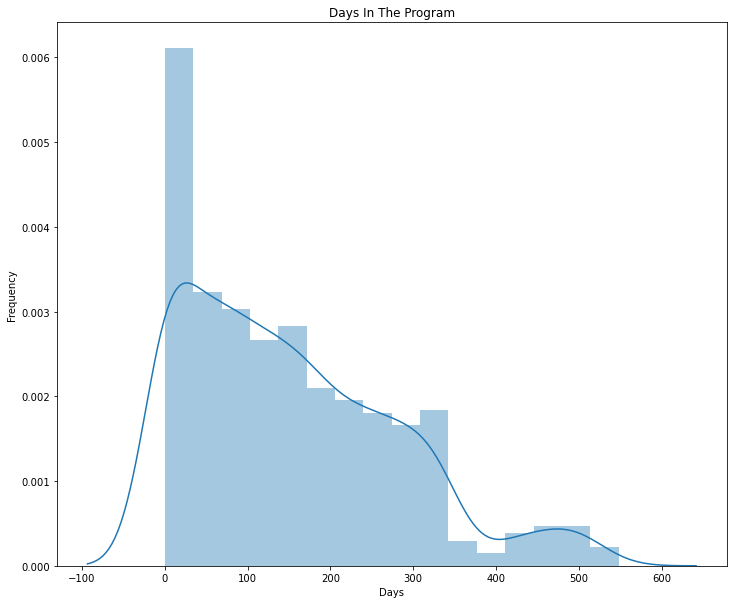

In [40]:
#Plot the distribution of the feature, days_program

plt.figure(figsize=(12,10))
sns.distplot(df_copy["days_program"])
# Label the axes
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.title('Days In The Program')
# Show the figure
plt.show()


The feature is distributed unevenly and the data is skewed to the right. A red flag is the large amount of fellows who were a part of the program for less than a day. Now that we knoew it is skewed to the right we can use the median, which is less than the mean. Another good thing is that the distribution is unimodal, meaning the feature contains a single highest value.

# log transformation to normalize data
I decided that I will keep the empty values out of the data moving forward.

In [41]:
def normal(data):
    """
    Returns True if the data given is normal ie. the p-value is less than 0.05. 
    If not, then return False.
    
    Parameters:
    data - The data to test normality of.
    
    Returns True if the data is normal, False otherwise.
    """

    _, p = stats.normaltest(data, nan_policy = 'omit')
    if p < 0.05:
        return False
    else:
        return True

In [42]:
if normal(df['days_program']):
    print('The data is normal!')
else:
    print('It is not normal!!!!!!!')

normal(df['days_program'])

It is not normal!!!!!!!


False

In [43]:
print('Skewness:', df['days_program'].skew())
print('Kurtosis:', df['days_program'].kurtosis())

Skewness: 0.814491075462124
Kurtosis: 0.004898726826255473


##### Skewness
The skewness is .814, and the Kurtosis is .0049.
A skewness of .814 means the data is moderately skewed, a kurtosis(describes the shape)  of .0049 is less than 3 which means it is platykurtic. The distribution is not normal.

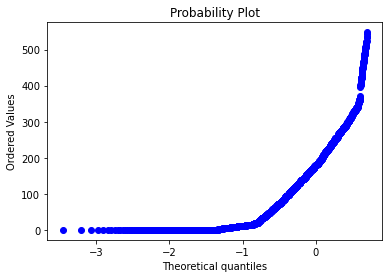

In [44]:
prob_plot = stats.probplot(df['days_program'], plot = plt)

In [45]:
#Find the median because it is not normalized
df['days_program'].median()
#Median == 112

112.0

#### Key take aways froms skewness tests and distribution
1. The median, skewness/Kurtosis value, and histogram of the distribution all indicate that the data is unimodal distribution skewed to the right.
2. Biggest issue is that many fellows did not particapte in the program(0 days in the program) and it has been included in the analysis. 
3. The data is NOT normal and we need to normalize the data. 


# Imputing the data through linear regression modeling
**The decision to impute the data rather than remove the missing is mainly because the data file is small. I want to include as many data values as possible to increase the effectiveness of our two models. 
1. imputation through linear regression 

In [46]:
#Break the data into categorical and quantitative features 
cat_feat = ['gender', 'race', 'pathrise_status', 'employment_status ', 
              'education', 'length_of_job_search', 
              'professional_experience', 'work_authorization_status', 
              'primary_track', 'cohort_tag', 'placed']
quant_feat = ['number_of_interviews', 'number_of_applications']

In [47]:
# One-hot encode cat_feat
df_impute = pd.get_dummies(df[cat_feat])

In [48]:
#bring in quantitative features
df_impute[quant_feat] = df[quant_feat]

In [49]:
#impute number of interviews using the median
df_impute['number_of_interviews'].fillna(df_impute['number_of_interviews'].median(), inplace = True)

In [50]:
df_impute['days_program'] = df['days_program']

In [51]:
#The linear regression model, train the data on the days_program
#that is not missing days_program -- The model will predict the 
#days_program missing values. (notnull = nonmissing values, isna = missing values)

training_set = df_impute[df_impute['days_program'].notnull()]
testing_set = df_impute[df_impute['days_program'].isna()]

X_train = training_set.iloc[:, 0:-1]
y_train = training_set['days_program']

# Train the model
lin_reg = LinearRegression().fit(X_train.values, y_train.values)

# Check out first 10 predictions
X_test = testing_set.iloc[:, 0:-1]
lin_reg.predict(X_test)[0:10]
#These values are extreme and are not consistent with the other values in the feature

array([-1.18150826e-01,  6.42659774e+01,  1.34725525e+02,  1.07325338e+02,
        8.82978178e+01,  1.27878371e+02,  6.74872519e+01,  8.18132705e+01,
        1.38341055e+02,  1.10146793e+02])

In [52]:
#I will try again using the Lasso method
clf = linear_model.Lasso(alpha = 0.1)
clf.fit(X_train.values, y_train.values)

# Check out first 10 predictions
clf.predict(X_test)[0:10]

#These values are more consistent and this is exactly what we needed

array([  1.35057962,  67.99356832, 135.97402776, 112.83874142,
        94.47844414, 123.51886227,  73.22499128,  86.60057518,
       133.78489706, 113.22897031])

In [53]:
df.loc[testing_set.index.values, "days_program"] = clf.predict(X_test)

In [54]:
df.isna().sum()

id                               0
pathrise_status                  0
primary_track                    0
cohort_tag                       8
days_program                     0
placed                           0
employment_status              229
education                       58
length_of_job_search            74
biggest_challenge_in_search     24
professional_experience        222
work_authorization_status      284
number_of_interviews           218
number_of_applications           0
gender                         492
race                            18
dtype: int64

### Now it is time to clean up the data a little more, focusing solely on the na values
1. either drop na if there are not many values
2. use fillna to fill in the missing values
3. possibly imputing using the median() value

In [55]:
#drop na values for these three features because there are not many empty values
df.dropna(subset = ["work_authorization_status", 'employment_status ','education', 'length_of_job_search','gender', 'race', 'cohort_tag', 'biggest_challenge_in_search',"number_of_interviews",], inplace = True)


In [56]:
#professional_experience
df['employment_status '].fillna('MISSING_EMPL_STATUS', inplace = True)

In [57]:

df.isna().sum()

id                               0
pathrise_status                  0
primary_track                    0
cohort_tag                       0
days_program                     0
placed                           0
employment_status                0
education                        0
length_of_job_search             0
biggest_challenge_in_search      0
professional_experience        131
work_authorization_status        0
number_of_interviews             0
number_of_applications           0
gender                           0
race                             0
dtype: int64

### Simple log transformation (continued)


In [58]:
#Simply log transformation
df["log_days"] = df["days_program"].apply(lambda x: np.log(abs(x)) if x > 0 else 0)


In [59]:
df["log_days"]

0       0.300534
1       4.219413
2       0.000000
3       0.000000
4       4.488636
          ...   
2534    4.779123
2538    4.770685
2539    6.124683
2541    4.947321
2543    5.652489
Name: log_days, Length: 1447, dtype: float64

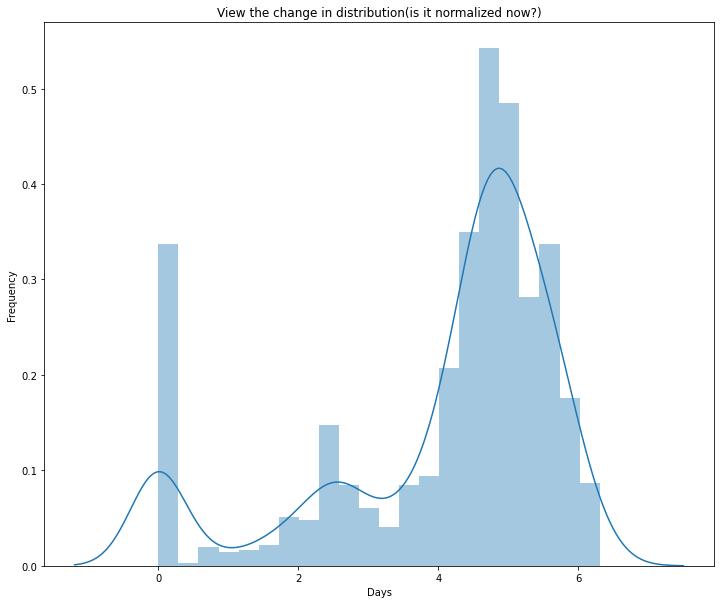

In [60]:
plt.figure(figsize=(12,10))
sns.distplot(df["log_days"])
# Label the axes
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.title('View the change in distribution(is it normalized now?)')
# Show the figure
plt.show()

In [61]:
df

,id,pathrise_status,primary_track,cohort_tag,days_program,placed,employment_status,education,length_of_job_search,biggest_challenge_in_search,professional_experience,work_authorization_status,number_of_interviews,number_of_applications,gender,race,log_days
0,1,enrolled,SWE,OCT19A,1.350580,0,Unemployed,Bachelor's Degree,3-5 months,Hearing back on my applications,3-4 years,Canada Citizen,2.0,900,Male,Non-Hispanic White or Euro-American,0.300534
1,2,enrolled,PSO,JAN20A,67.993568,0,Unemployed,"Some College, No Degree",3-5 months,Getting past final round interviews,1-2 years,Citizen,6.0,0,Male,Non-Hispanic White or Euro-American,4.219413
2,3,enrolled,Design,AUG19B,0.000000,0,Employed Part-Time,Master's Degree,Less than one month,Figuring out which jobs to apply for,Less than one year,Citizen,0.0,0,Male,East Asian or Asian American,0.000000
3,4,enrolled,PSO,AUG19B,0.000000,0,Contractor,Bachelor's Degree,Less than one month,Getting past final round interviews,Less than one year,Citizen,5.0,25,Male,Decline to Self Identify,0.000000
4,5,enrolled,SWE,AUG19A,89.000000,1,Unemployed,Bachelor's Degree,1-2 months,Hearing back on my applications,1-2 years,F1 Visa/OPT,10.0,100,Male,East Asian or Asian American,4.488636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2534,2535,enrolled,SWE,MAR20A,119.000000,1,Employed Full-Time,Bachelor's Degree,1-2 months,Getting past phone screens,1-2 years,Citizen,0.0,10,Male,South Asian or Indian American,4.779123
2538,2539,not_enrolled,SWE,JUL19B,118.000000,0,Employed Part-Time,Master's Degree,Less than one month,Lack of relevant experience,5+ years,Other,1.0,25,Decline to Self Identify,Middle Eastern or Arab American,4.770685
2539,2540,enrolled,Design,JUN18A,457.000000,0,Contractor,Master's Degree,6 months to a year,Technical interviewing,5+ years,Citizen,4.0,15,Male,Non-Hispanic White or Euro-American,6.124683
2541,2542,enrolled,SWE,SEP18C,140.797204,0,Contractor,Bachelor's Degree,Less than one month,Technical interviewing,1-2 years,Citizen,1.0,30,Female,Non-Hispanic White or Euro-American,4.947321


# Modeling
Reviewing the problem again, it is critical to clearly state the problem. 

### Problem Overview

We will be utilizing two different models

#1. Regression model: To determine WHEN a fellow will be placed. Due to deadline requirements, I will only conduct a classification model. I will continue to work on the regression model in the mean time.  

#2. Classification model: to determine IF a fellow will be placed.


The two dependant variables are clear, for classification the dependent variable is placed, and for the regression model the dependent variable is days_program.

### One Hot encoding, independent variables

# Categoical Variables

In [62]:
df

,id,pathrise_status,primary_track,cohort_tag,days_program,placed,employment_status,education,length_of_job_search,biggest_challenge_in_search,professional_experience,work_authorization_status,number_of_interviews,number_of_applications,gender,race,log_days
0,1,enrolled,SWE,OCT19A,1.350580,0,Unemployed,Bachelor's Degree,3-5 months,Hearing back on my applications,3-4 years,Canada Citizen,2.0,900,Male,Non-Hispanic White or Euro-American,0.300534
1,2,enrolled,PSO,JAN20A,67.993568,0,Unemployed,"Some College, No Degree",3-5 months,Getting past final round interviews,1-2 years,Citizen,6.0,0,Male,Non-Hispanic White or Euro-American,4.219413
2,3,enrolled,Design,AUG19B,0.000000,0,Employed Part-Time,Master's Degree,Less than one month,Figuring out which jobs to apply for,Less than one year,Citizen,0.0,0,Male,East Asian or Asian American,0.000000
3,4,enrolled,PSO,AUG19B,0.000000,0,Contractor,Bachelor's Degree,Less than one month,Getting past final round interviews,Less than one year,Citizen,5.0,25,Male,Decline to Self Identify,0.000000
4,5,enrolled,SWE,AUG19A,89.000000,1,Unemployed,Bachelor's Degree,1-2 months,Hearing back on my applications,1-2 years,F1 Visa/OPT,10.0,100,Male,East Asian or Asian American,4.488636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2534,2535,enrolled,SWE,MAR20A,119.000000,1,Employed Full-Time,Bachelor's Degree,1-2 months,Getting past phone screens,1-2 years,Citizen,0.0,10,Male,South Asian or Indian American,4.779123
2538,2539,not_enrolled,SWE,JUL19B,118.000000,0,Employed Part-Time,Master's Degree,Less than one month,Lack of relevant experience,5+ years,Other,1.0,25,Decline to Self Identify,Middle Eastern or Arab American,4.770685
2539,2540,enrolled,Design,JUN18A,457.000000,0,Contractor,Master's Degree,6 months to a year,Technical interviewing,5+ years,Citizen,4.0,15,Male,Non-Hispanic White or Euro-American,6.124683
2541,2542,enrolled,SWE,SEP18C,140.797204,0,Contractor,Bachelor's Degree,Less than one month,Technical interviewing,1-2 years,Citizen,1.0,30,Female,Non-Hispanic White or Euro-American,4.947321


In [63]:
cat_feat = [
    "primary_track", "cohort_tag", 
    "employment_status ", "education", "length_of_job_search",
    "professional_experience", "work_authorization_status","gender","race"
]

# I will not include the feature pathrise_status, because it contains only one value:enrolled. 
#All the individuals in the df_copy dataframe are fellows and they particpated in the program.
#I thought about removing race and gender features but decided that they could provide some useful insights on the data.
    
    
    

In [64]:
#Create a one-hot encoding function for classification categorical variables

one_hot_classification = []
one_hot_regression = []

def one_hot(variable, for_placed = True):
    for u_variable in df[variable].unique():
        if for_placed: 
            one_hot_classification.append(u_variable)
        else:
            one_hot_regression.append(u_variable)
    
    df_new_dum = pd.get_dummies(df[variable])    
    df[df_new_dum.columns] = df_new_dum


# Independent Variable Analysis
This needs to be done prior to modeling/hot encoding

### Independent variable 1, Primary Track

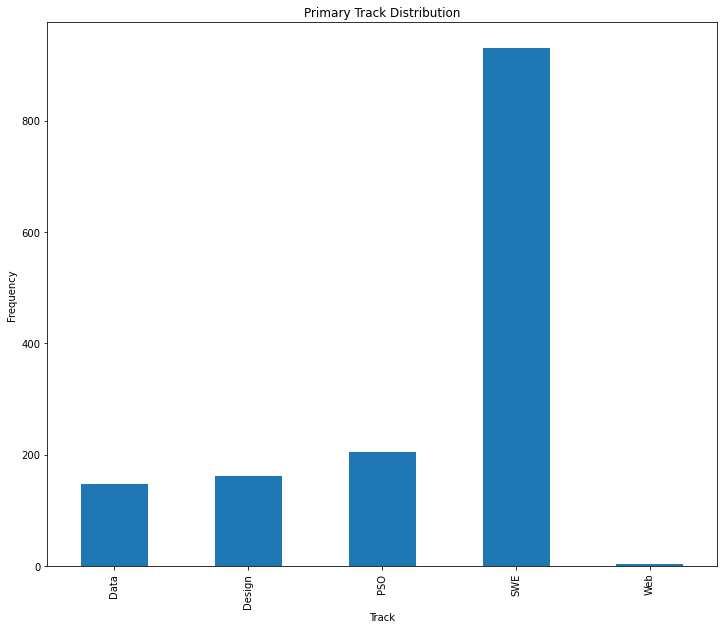

In [65]:
plt.figure(figsize=(12,10))
df.groupby("primary_track").size().plot(kind='bar')
# Label the axes
plt.xlabel("Track")
plt.ylabel("Frequency")
plt.title("Primary Track Distribution")
# Show the figure
plt.show()

### Check missing values of primary track

In [66]:
print("Are there any NaN or empty values in the column?", df_copy["primary_track"].isnull().values.any(), "\nThere are: ",
df["primary_track"].isnull().values.sum(), "in the column")


Are there any NaN or empty values in the column? False 
There are:  0 in the column


The primary track feature, describes the career path of the fellow. There are six different career paths, data science, design, marketing, PSO, SWE, and Web. In the image we can clearly see that majority of the enrolled fellows are Software Engineers (SWE). Another important thing to note is that there are no missing values for the primary track feature.  

### Independent variable 2, Cohort Tag


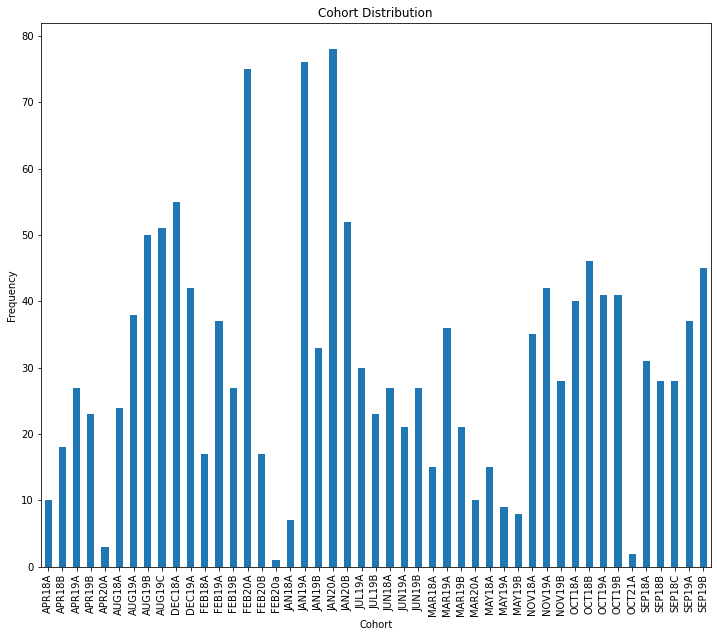

In [67]:
plt.figure(figsize=(12,10))
df.groupby("cohort_tag").size().plot(kind='bar')
# Label the axes
plt.xlabel("Cohort")
plt.ylabel("Frequency")
plt.title("Cohort Distribution")
# Show the figure
plt.show()

In [68]:
print(df["cohort_tag"].value_counts())
#There is an issue with Cohort in the data, there seems to be lowercases in some of the cohorts,
#and I assume these are typos.

df_lower = df["cohort_tag"] == "FEB20a"
df_upper = df["cohort_tag"] == "FEB20A"

print("There were",df_lower.values.sum(), "fellows with in Cohort FEB20a")
print("There were",df_upper.values.sum(), "fellows with in Cohort FEB20A")

#Quick fix

df["cohort_tag"] = df["cohort_tag"].replace("FEB20a","FEB20A")
df_lower2 = df["cohort_tag"] == "FEB20a"
print("There were",df_lower2.values.sum(), "fellows with in Cohort FEB20a")

#All I did was replace FEB20a with FEB20A
#Another issue, OCT21A-- a future day possibly a typo, but because there is no OCT 20 I do
#not want to take the risk of including this data with OCT19 and decided it is best for the data
#to be removed from the data.
print(df.shape)
df.drop(df[df["cohort_tag"] == "OCT21A"].index, inplace = True)
print(df.shape)


JAN20A    78
JAN19A    76
FEB20A    75
DEC18A    55
JAN20B    52
AUG19C    51
AUG19B    50
OCT18B    46
SEP19B    45
NOV19A    42
DEC19A    42
OCT19A    41
OCT19B    41
OCT18A    40
AUG19A    38
FEB19A    37
SEP19A    37
MAR19A    36
NOV18A    35
JAN19B    33
SEP18A    31
JUL19A    30
SEP18B    28
SEP18C    28
NOV19B    28
FEB19B    27
JUN19B    27
APR19A    27
JUN18A    27
AUG18A    24
JUL19B    23
APR19B    23
MAR19B    21
JUN19A    21
APR18B    18
FEB18A    17
FEB20B    17
MAY18A    15
MAR18A    15
APR18A    10
MAR20A    10
MAY19A     9
MAY19B     8
JAN18A     7
APR20A     3
OCT21A     2
FEB20a     1
Name: cohort_tag, dtype: int64
There were 1 fellows with in Cohort FEB20a
There were 75 fellows with in Cohort FEB20A
There were 0 fellows with in Cohort FEB20a
(1447, 17)
(1445, 17)


### Independent variable 3, Employment Status


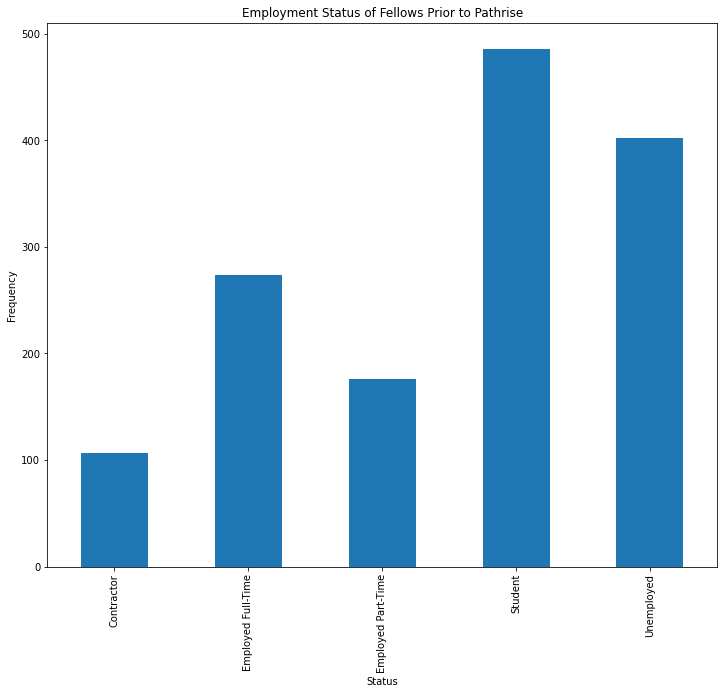

In [69]:
plt.figure(figsize=(12,10))
df.groupby("employment_status ").size().plot(kind='bar')
# Label the axes
plt.xlabel("Status")
plt.ylabel("Frequency")
plt.title("Employment Status of Fellows Prior to Pathrise")
# Show the figure
plt.show()

### Independent variable 4, Education


We determine earlier that education does not play a big part in placement, rather it plays a bigger part in being included in the program. 

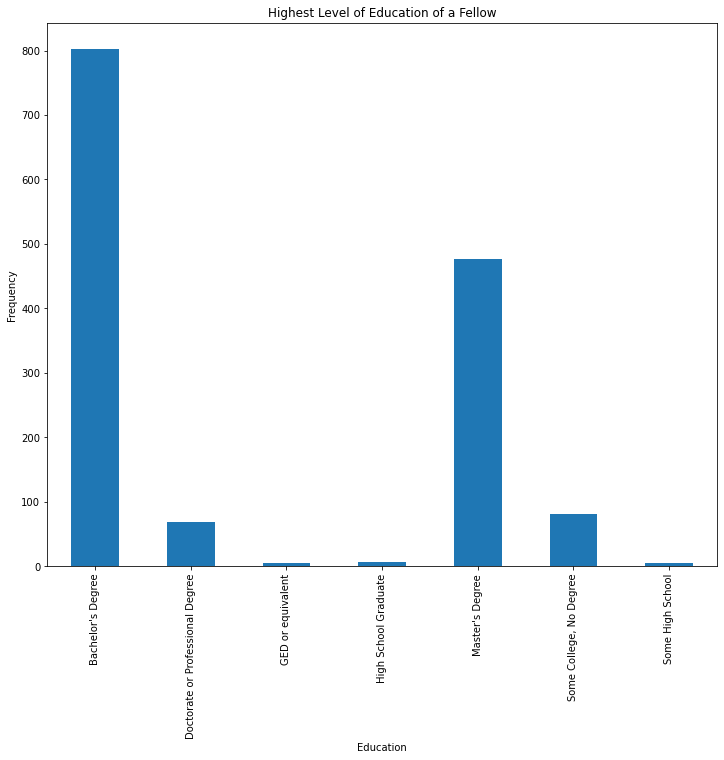

In [70]:
plt.figure(figsize=(12,10))
df.groupby("education").size().plot(kind='bar')
# Label the axes
plt.xlabel("Education")
plt.ylabel("Frequency")
plt.title("Highest Level of Education of a Fellow")
# Show the figure
plt.show()

The feature, education, describes the highest level of education a fellow has received. We can see in the visual of the distribution, that majority of the fellows in the program received either a Bachelor’s Degree or a Master’s Degree. In our earlier analysis of placement and education we determine that education level did not affect placement, but the data suggest that fellows with higher education are more likely to successful joining the program. Prior to the analysis I assumed the higher the education level of a fellow the more likely a fellow will be placed, but the data makes it evident that there is no strong relationship between placement and education. 

### Independent variable 5, Length of Job Search


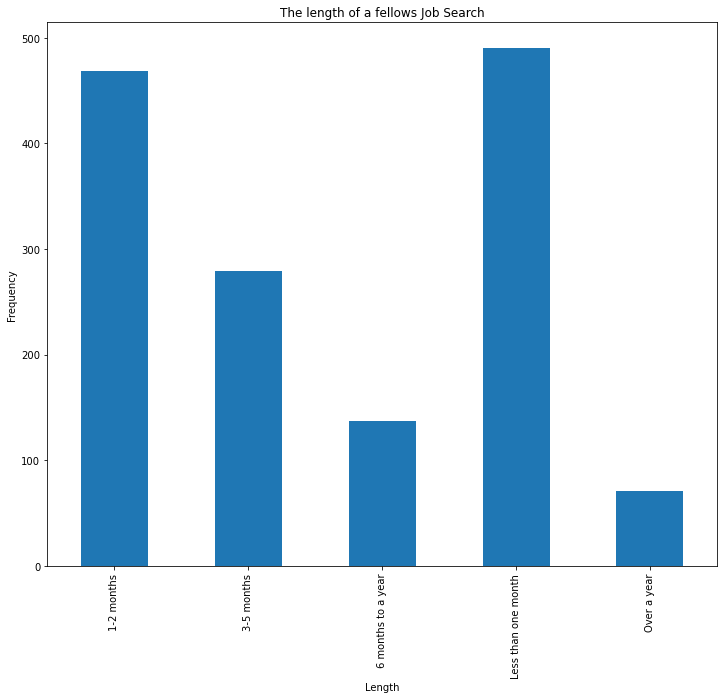

In [71]:
plt.figure(figsize=(12,10))
df.groupby("length_of_job_search").size().plot(kind='bar')
# Label the axes
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.title("The length of a fellows Job Search")
# Show the figure
plt.show()

### Independent variable 6, Work Authorization Status


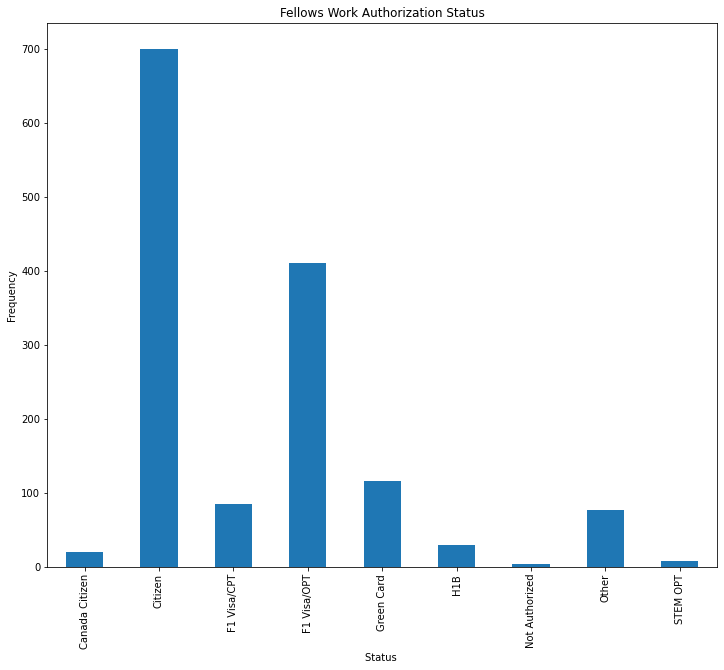

In [72]:
plt.figure(figsize=(12,10))
df.groupby("work_authorization_status").size().plot(kind='bar')
# Label the axes
plt.xlabel("Status ")
plt.ylabel("Frequency")
plt.title("Fellows Work Authorization Status")
# Show the figure
plt.show()

Many of the fellows are American Citizens or have the F1 Visa/OPT. Work Authorization is a big factor in getting placed with company due to many companies seeking individuals with authorization to work in the United States. It is a rather huge obstacle for a company to sponser an applicant. 

### Independent variable 7, Professional Experience


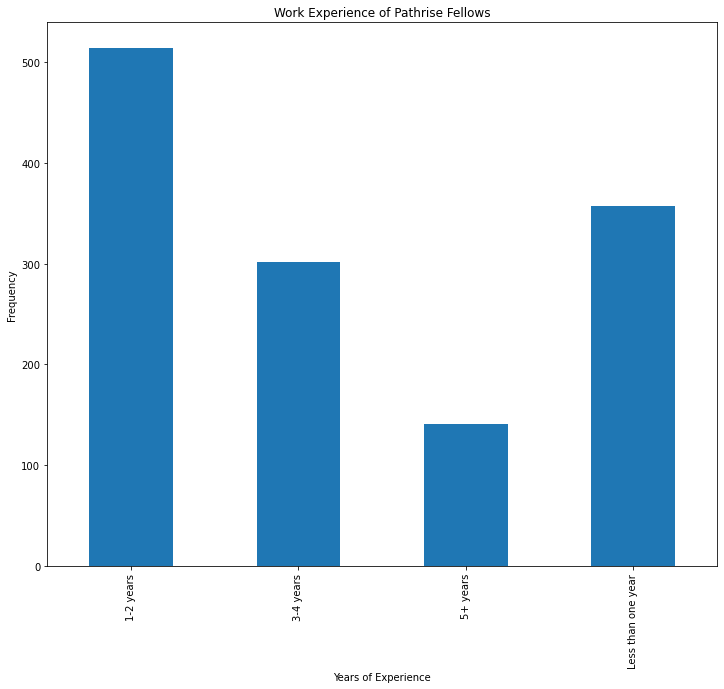

In [73]:
plt.figure(figsize=(12,10))
df.groupby("professional_experience").size().plot(kind='bar')
# Label the axes
plt.xlabel("Years of Experience")
plt.ylabel("Frequency")
plt.title("Work Experience of Pathrise Fellows")
# Show the figure
plt.show()

### Independent variable 8, Race


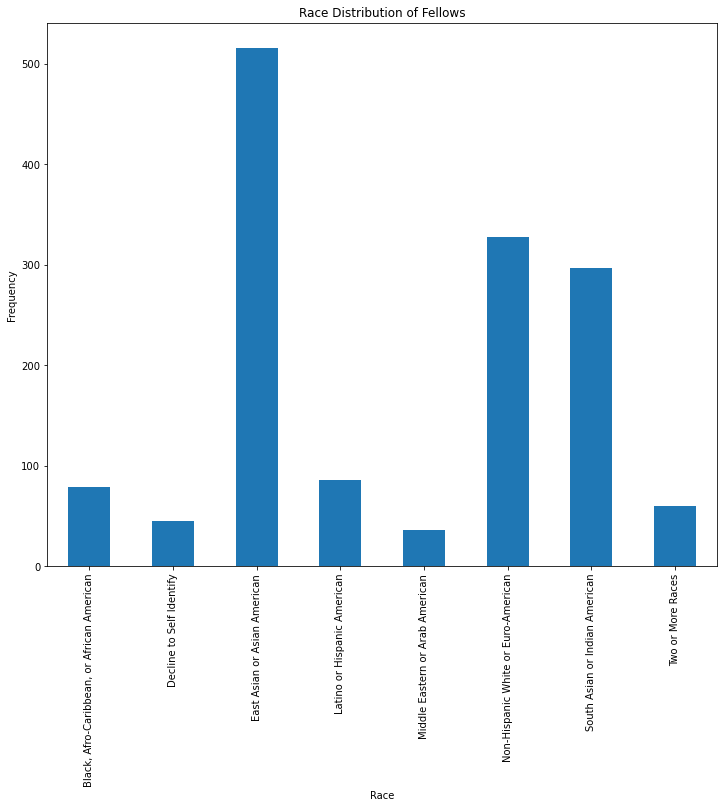

In [74]:
plt.figure(figsize=(12,10))
df.groupby("race").size().plot(kind='bar')
# Label the axes
plt.xlabel("Race")
plt.ylabel("Frequency")
plt.title("Race Distribution of Fellows")
# Show the figure
plt.show()

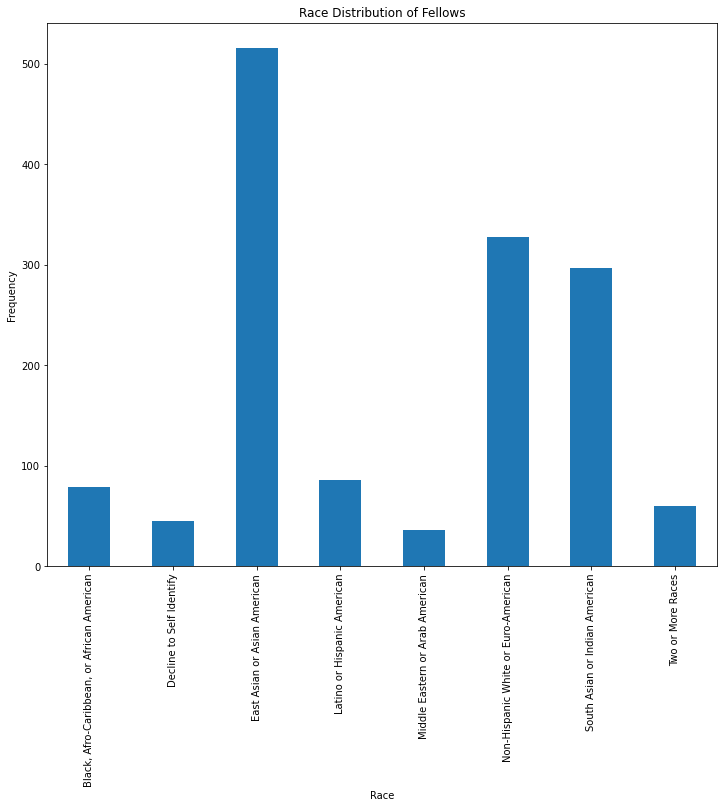

In [75]:
#The visual distribution above does not include the missing values. 
plt.figure(figsize=(12,10))
df.groupby("race").size().plot(kind='bar')
# Label the axes
plt.xlabel("Race")
plt.ylabel("Frequency")
plt.title("Race Distribution of Fellows")
# Show the figure
plt.show()

### Independent variable 9, Gender


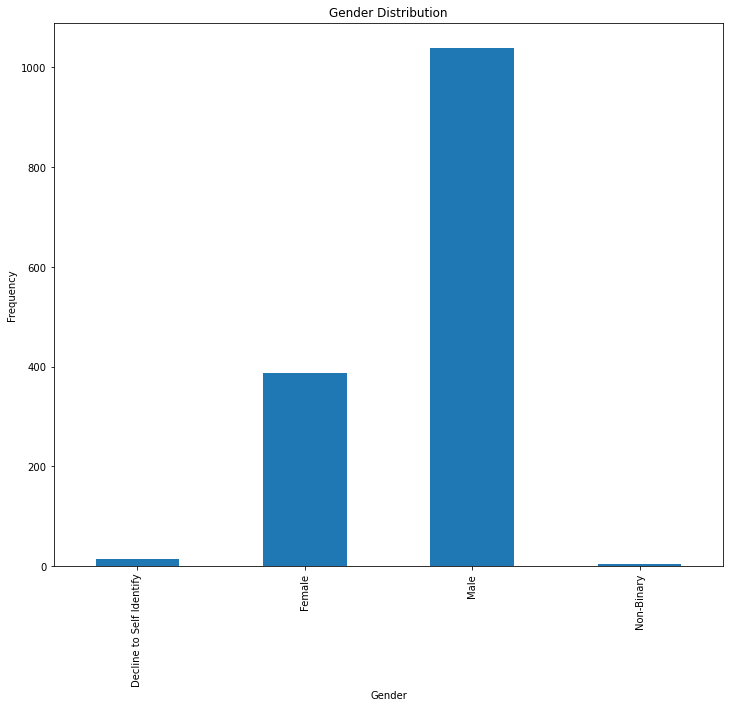

In [76]:
plt.figure(figsize=(12,10))
df.groupby("gender").size().plot(kind='bar')
# Label the axes
plt.xlabel("Gender")
plt.ylabel("Frequency")
plt.title("Gender Distribution")
# Show the figure
plt.show()

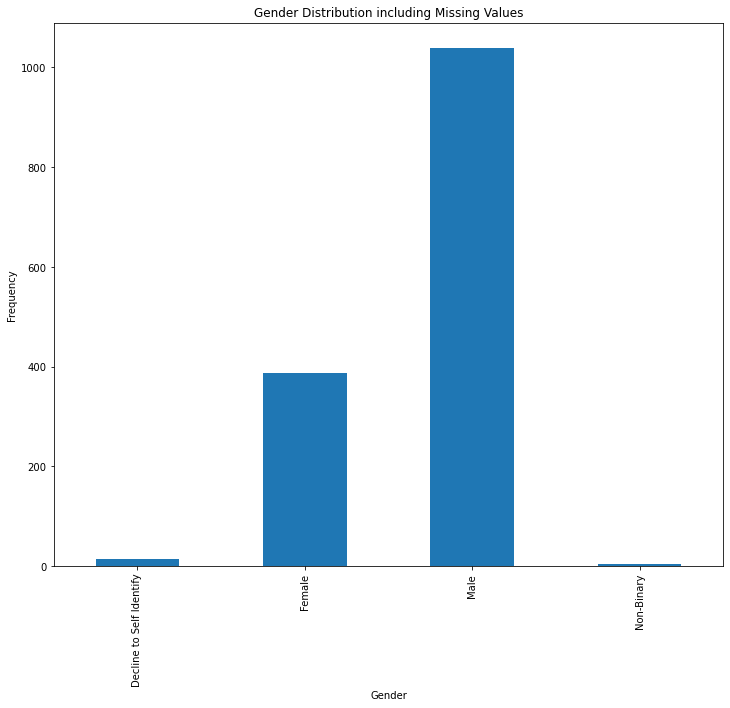

In [77]:
#The visual distribution above does not include the missing values. 
plt.figure(figsize=(12,10))
df.groupby("gender").size().plot(kind='bar')
# Label the axes
plt.xlabel("Gender")
plt.ylabel("Frequency")
plt.title("Gender Distribution including Missing Values")
# Show the figure
plt.show()

# Chi-Square Test

In order to determine if the categorical variables and the dependent variables have a significant relationship we need to run a Chi-square test. If the p-value is less than .05 then we can reject the null value and there is a significant relationship between the dependent variable and the categorical variable. Chi-square test is discussed in more depth in the research paper.

In [78]:
sig_classification = [] 
for cat in cat_feat:    
    cross_table = pd.crosstab((df[cat]), df['placed'],margins = False)
    stat, p, dof, expected = stats.chi2_contingency(cross_table.values)
    if p < 0.05:
        sig_classification.append(cat)

In [79]:
print("These categorical independent variables:",  sig_classification,"interact with placed, the dependent variable")
df

These categorical independent variables: ['primary_track', 'cohort_tag', 'gender', 'race'] interact with placed, the dependent variable


,id,pathrise_status,primary_track,cohort_tag,days_program,placed,employment_status,education,length_of_job_search,biggest_challenge_in_search,professional_experience,work_authorization_status,number_of_interviews,number_of_applications,gender,race,log_days
0,1,enrolled,SWE,OCT19A,1.350580,0,Unemployed,Bachelor's Degree,3-5 months,Hearing back on my applications,3-4 years,Canada Citizen,2.0,900,Male,Non-Hispanic White or Euro-American,0.300534
1,2,enrolled,PSO,JAN20A,67.993568,0,Unemployed,"Some College, No Degree",3-5 months,Getting past final round interviews,1-2 years,Citizen,6.0,0,Male,Non-Hispanic White or Euro-American,4.219413
2,3,enrolled,Design,AUG19B,0.000000,0,Employed Part-Time,Master's Degree,Less than one month,Figuring out which jobs to apply for,Less than one year,Citizen,0.0,0,Male,East Asian or Asian American,0.000000
3,4,enrolled,PSO,AUG19B,0.000000,0,Contractor,Bachelor's Degree,Less than one month,Getting past final round interviews,Less than one year,Citizen,5.0,25,Male,Decline to Self Identify,0.000000
4,5,enrolled,SWE,AUG19A,89.000000,1,Unemployed,Bachelor's Degree,1-2 months,Hearing back on my applications,1-2 years,F1 Visa/OPT,10.0,100,Male,East Asian or Asian American,4.488636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2534,2535,enrolled,SWE,MAR20A,119.000000,1,Employed Full-Time,Bachelor's Degree,1-2 months,Getting past phone screens,1-2 years,Citizen,0.0,10,Male,South Asian or Indian American,4.779123
2538,2539,not_enrolled,SWE,JUL19B,118.000000,0,Employed Part-Time,Master's Degree,Less than one month,Lack of relevant experience,5+ years,Other,1.0,25,Decline to Self Identify,Middle Eastern or Arab American,4.770685
2539,2540,enrolled,Design,JUN18A,457.000000,0,Contractor,Master's Degree,6 months to a year,Technical interviewing,5+ years,Citizen,4.0,15,Male,Non-Hispanic White or Euro-American,6.124683
2541,2542,enrolled,SWE,SEP18C,140.797204,0,Contractor,Bachelor's Degree,Less than one month,Technical interviewing,1-2 years,Citizen,1.0,30,Female,Non-Hispanic White or Euro-American,4.947321


### One Hot encode 

In [80]:
one_hot_classification

[]

In [81]:
for i in sig_classification:
    one_hot(i, True)


# Which categorical variables have a significant relationship with days_program (regression problem)

In [82]:
def determine_sig_anova(cat, dv):
    """
    Determines the significance of a categorical variable using an ANOVA test.
    
    Parameters:
    categ_var - The feature to test on.
    dv - The feature to test against.
    
    Returns True if the groups are different, False otherwise
    """
    levels = df[cat].unique()
    all_types = [] # List of lists for each level's program_duration_days
    for level in levels:
        prog_dur_days = df[df[cat] == level][dv].values
        all_types.append(prog_dur_days)
    
    # Reject H0?
    pval = stats.f_oneway(*all_types)[1]
    if pval < 0.05:
        return True
    else:
        return False

In [83]:
timer = [] # Holds statistically significant variables for regression problem

for cat in cat_feat:
    if determine_sig_anova(cat, 'days_program'):
        timer.append(cat)

In [84]:
timer 

['cohort_tag', 'work_authorization_status', 'gender']

In [85]:
for time_1 in timer:
    one_hot(time_1, False)

In [86]:
time_1

'gender'

### The signifcant categorical features for the models
#### Classification Model:
1. primary_track
2. cohort_tag
3. gender
4. race

#### Regression Model:
1. cohort_tag
2. work_authorization_status
3. gender

# Quantitative variables

In [87]:
#These are the three quantitative variables I am going to focus on for the classification model and the regression model
print(df["number_of_interviews"])
print(df["number_of_applications"])
print(df["professional_experience"])



0        2.0
1        6.0
2        0.0
3        5.0
4       10.0
        ... 
2534     0.0
2538     1.0
2539     4.0
2541     1.0
2543     3.0
Name: number_of_interviews, Length: 1445, dtype: float64
0       900
1         0
2         0
3        25
4       100
       ... 
2534     10
2538     25
2539     15
2541     30
2543     70
Name: number_of_applications, Length: 1445, dtype: int64
0                3-4 years
1                1-2 years
2       Less than one year
3       Less than one year
4                1-2 years
               ...        
2534             1-2 years
2538              5+ years
2539              5+ years
2541             1-2 years
2543             1-2 years
Name: professional_experience, Length: 1445, dtype: object


### Analyze the distribution of the quantitative variables

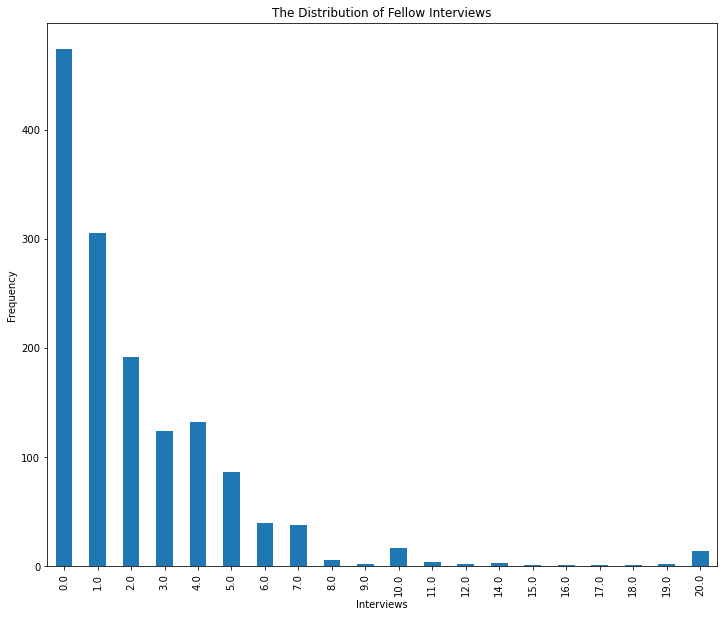

In [88]:
#The visual distribution above does not include the missing values. 
plt.figure(figsize=(12,10))
df.groupby("number_of_interviews").size().plot(kind='bar')
# Label the axes
plt.xlabel("Interviews")
plt.ylabel("Frequency")
plt.title("The Distribution of Fellow Interviews")
# Show the figure
plt.show()

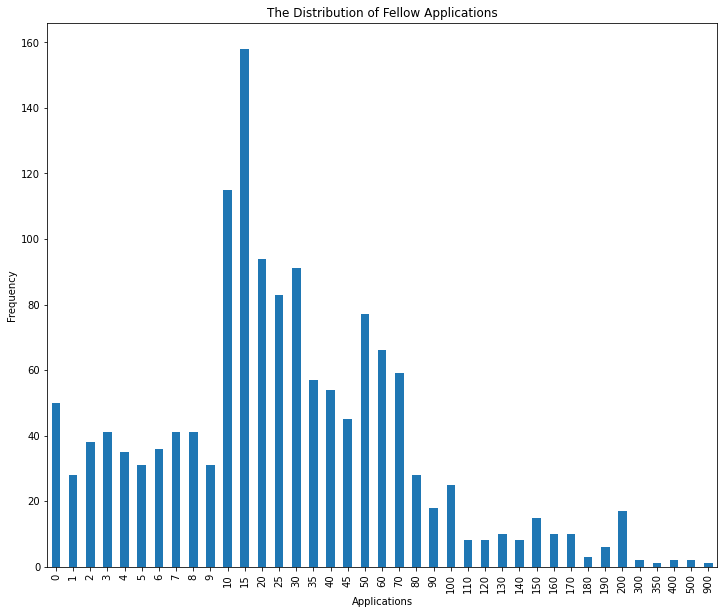

In [89]:
#The visual distribution above does not include the missing values. 
plt.figure(figsize=(12,10))
df.groupby("number_of_applications").size().plot(kind='bar')
# Label the axes
plt.xlabel("Applications")
plt.ylabel("Frequency")
plt.title("The Distribution of Fellow Applications")
# Show the figure
plt.show()

### Convert Professional experience into a quantitative variable
Feature Engineering

In [90]:
print(df["professional_experience"].value_counts())

1-2 years             514
Less than one year    357
3-4 years             302
5+ years              141
Name: professional_experience, dtype: int64


The idea will be to convert the value, "less than one year" to 6 representing months, 1-2 years converting it to 18 months (1.5 years), 3-4 years to 42 months and 5+months to 60 months.


In [91]:
df["professional_experience"] = df["professional_experience"].replace(["Less than one year"], 6)
df["professional_experience"] = df["professional_experience"].replace(["1-2 years"], 18)
df["professional_experience"] = df["professional_experience"].replace(["3-4 years"], 42)
df["professional_experience"] = df["professional_experience"].replace(["5+ years"], 60)
df["professional_experience"].value_counts()


18.0    514
6.0     357
42.0    302
60.0    141
Name: professional_experience, dtype: int64

In [92]:
#These are for the classification problem (PLACEMENT)
quan = ["days_program","number_of_interviews", "number_of_applications", "professional_experience"]
quan_hot =[]

In [93]:
quan

['days_program',
 'number_of_interviews',
 'number_of_applications',
 'professional_experience']

In [94]:
quan_placed = []

In [95]:
for quan_1 in quan:
    if determine_sig_anova('placed', quan_1):
        quan_placed.append(quan_1)


In [96]:
def anova(cat, var):
    ls = df[cat].unique()
    listt = []
    for l in ls:
        days = df[df[cat] == l][var].values
        listt.append(days)
    p_value = stats.f_oneway(*listt)[1]
    if p_value < 0.05:
        return True
    else:
        return False

In [97]:
stat_quan = []

for q in quan:
    if anova('placed', q):
        stat_quan.append(q)

In [98]:
print("These quantitative independent variables:",  stat_quan ,"interact with placed, the dependent variable")

These quantitative independent variables: ['days_program'] interact with placed, the dependent variable


### Quantitative overview

I thought there would be more than just one quantitative variable that interacted with placed. I am not surprised that days_program was the variable(days_program is independent variable in the classification model, but dependent in the regression model). The amount of interviews a fellow has recieved or the amount of applications that fellow submitted does not have a signficant impact on placement, which is odd in my opinion. 

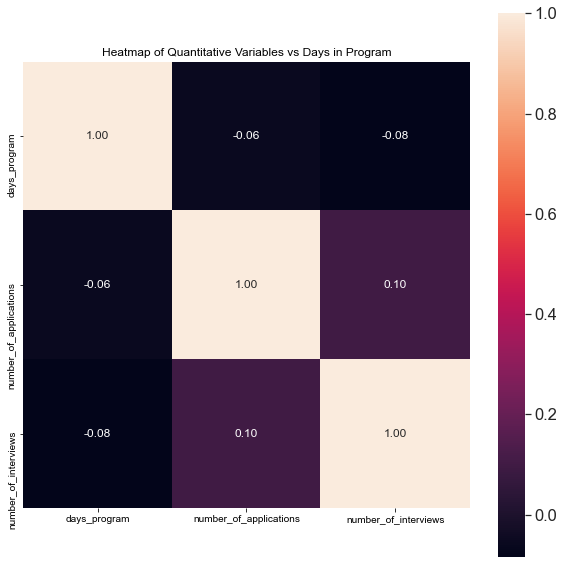

In [99]:
# Get a quick look at the correlations between the quantitative variables and placement
corrmat = df_copy[["days_program", 'number_of_interviews', 'number_of_applications']].corr()

f, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Heatmap of Quantitative Variables vs Days in Program')
k = 10 
cols = corrmat.nlargest(k, 'days_program')['days_program'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, 
                 square=True, fmt='.2f', annot_kws={'size': 12}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#### Heat Map Analysis
So there is nothing that really stands out in the heatmap. Unfortunately I will exclude all quantitive features from the regression model, no value is greater than .10 (Closer to 1 the more significant the relationship). Currently the number of applications and number of interviews both are -.06 and -.08 respectively. 

# Modeling -- Classification Model

In [100]:
# Isolate the features for both the classifcation models 
placed_features = one_hot_classification + quan_hot 
placed_features.append("log_days")

placement_time_features = one_hot_regression + quan_hot

# Split into training and test sets for both the regression and classification models
placed_X_train_val, placed_X_test, placed_y_train_val, placed_y_test = train_test_split(df[placed_features].values, 
                                                                                        df['placed'].values, 
                                                                                        test_size = 0.2, 
                                                                                        random_state = 42)

placement_time_X_train_val, placement_time_X_test, placement_time_y_train_val, placement_time_y_test = train_test_split(df[placement_time_features].values, 
                                                                                                                    df['log_days'].values, 
                                                                                                                        test_size = 0.2, random_state = 42)

#number of folds
n_folds = 30

# Placement Time
#### It is important to note that I will be using F1 score as a metric to identify the models effectiveness becuase the data set is imbalanced. Accuracy would not be a good metric to assess the effectiveness of the model. 

# Logistic Model: Classification Model #1 

In [101]:
kf = KFold(n_splits = n_folds, shuffle = True, random_state = 42)

train_f1_scores = []
val_f1_scores = []
placed_lreg = LogisticRegression()

# Perform K-Fold CV
for train_inds, val_inds in kf.split(placed_X_train_val):
    X_train, X_val = placed_X_train_val[train_inds], placed_X_train_val[val_inds]
    y_train, y_val = placed_y_train_val[train_inds], placed_y_train_val[val_inds]
    
    placed_lreg.fit(X_train, y_train)
    train_preds = placed_lreg.predict(X_train)
    val_preds = placed_lreg.predict(X_val)
    
    train_f1_scores.append(f1_score(y_train, train_preds))
    val_f1_scores.append(f1_score(y_val, val_preds))

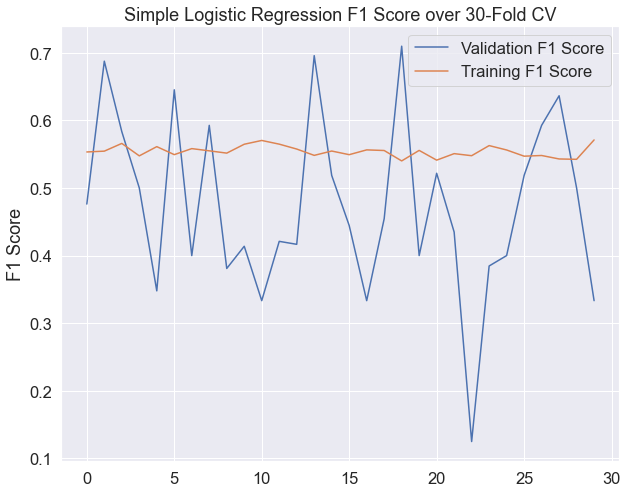

In [102]:
f, ax = plt.subplots(figsize=(10,8))
plt.plot(np.arange(0, n_folds), val_f1_scores, label = 'Validation F1 Score')
plt.plot(np.arange(0, n_folds), train_f1_scores, label = 'Training F1 Score')
plt.ylabel('F1 Score')
plt.title('Simple Logistic Regression F1 Score over 30-Fold CV')
plt.legend()
plt.show()

In [103]:
print('Best Validation F1 Score:', val_f1_scores[np.argmax(val_f1_scores)])
# See how well it performs on the test set
print('F1 Score on Test Set: %.4f' % f1_score(placed_y_test, placed_lreg.predict(placed_X_test)))

Best Validation F1 Score: 0.7096774193548387
F1 Score on Test Set: 0.5073


### Quick Logistic Regression Model Evulation
The model yielded an F1 score of .71 (best validation) and F1 Score of .51 on the test Set. The two scores are actually good and they both indicate that the model is effective.

### Compute ROC curve and AUC 


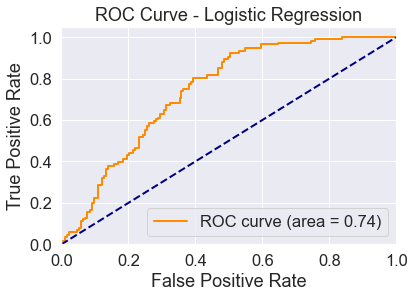

In [104]:
fpr, tpr, thresholds = roc_curve(placed_y_test, 
                                 placed_lreg.decision_function(placed_X_test))
calc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         lw = 2, label='ROC curve (area = %0.2f)' % calc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

### Analysis on the ROC Curve and AUC 
I get a AUC of .74 which is considered acceptable and the logistic regression model is a decent one. Although it is not a high .8 or even a .9 it is still acceptable and the model is effectively predicts if a pathrise fellow will be placed. 

### XGBOOST MODEL

In [107]:
xgb_fit_dict = {
    'eval_metric': 'auc',
    "early_stopping_rounds": 15,
    "eval_set": [(placed_X_test, placed_y_test)],
    'verbose': 100
}

xgb_param_dict = {
    'n_estimators': np.arange(10, 100, 10),
    'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'learning_rate': [0.05, 0.1, 0.3],
    'subsample': stats.uniform(loc=0.2, scale=0.8),
    'colsample_bytree': stats.uniform(loc=0.4, scale=0.6),
    'gamma': [0.0, 0.1, 0.2],
    'max_depth': [5, 7, 10],
    'min_child_samples': stats.randint(100, 500), 
    "objective": ["binary:logistic"],
    'alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
    'lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
}


placed_xgb_model = XGBClassifier(seed = 42, metric = 'None', n_jobs = 4, silent = True)

rs_clf = RandomizedSearchCV(placed_xgb_model, random_state = 42, 
                            param_distributions = xgb_param_dict, 
                            n_iter = 50, 
                            cv = n_folds, 
                            scoring = 'f1', 
                            verbose = False) 

In [114]:
from os import path
# Only train if there does not exist a saved model
placed_saved = 'placed_best.pickle.dat'

if path.exists(placed_saved):
    print('I already have a saved model.')
    
    # Load in saved model
    placed_best = pickle.load(open(placed_saved, 'rb'))
    
    print('Saved Model Parameters')
    print(placed_best.get_xgb_params())
    
    # Compute saved model's MSE for test set
    best_xgb_preds = placed_best.predict(placed_X_test)
    start = time.time()
    print("Model took %.2f seconds to complete." % (time.time()-start))
    print("F1 Score on Test Set: %.4f" % f1_score(placed_y_test, best_xgb_preds))
    
else:
    print('Starting to train...')
    
    # Fit via RandomizedSearch
    start = time.time()
    rs_clf.fit(placed_X_train_val, placed_y_train_val, **xgb_fit_dict)
    print("RandomizedSearch took %.2f seconds to complete." % (time.time()-start))
    
    # Get best params
    xgb_best_params = rs_clf.best_params_
    
    # Train using best params
    placed_best = XGBClassifier(**xgb_best_params, seed = 42)
    start = time.time()
    placed_best.fit(placed_X_train_val, placed_y_train_val)
    
    # Get MSE
    best_xgb_preds = placed_best.predict(placed_X_test)
    print("Model took %.2f seconds to complete." % (time.time()-start))
    print("F1 Score on Test Set: %.4f" % f1_score(placed_y_test, best_xgb_preds))
    
    # Save best xgb model
    pickle.dump(placed_best, open(placed_saved, 'wb'))

Starting to train...
[12:34:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.68181
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[47]	validation_0-auc:0.78182

[12:34:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	v

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[12]	validation_0-auc:0.77688

[12:34:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.72842
Will train until validation_0-auc hasn't improved in 15 rounds.
[69]	validation_0-auc:0.78112
[12:34:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

Will train until validation_0-auc hasn't improved in 15 rounds.
[69]	validation_0-auc:0.77397
[12:34:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.64747
Will train until validation_0-auc hasn't improved in 15 rounds.
[19]	validation_0-auc:0.65186
[12:34:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please 

[12:34:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.64747
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[3]	validation_0-auc:0.65300

[12:34:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.6388

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[1]	validation_0-auc:0.78483

[12:34:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77048
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[7]	validation_0-auc:0.78752

[12:34:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are no

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[6]	validation_0-auc:0.78558

[12:34:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76634
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[2]	validation_0-auc:0.78506

[12:34:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are no

Will train until validation_0-auc hasn't improved in 15 rounds.
[39]	validation_0-auc:0.72481
[12:34:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.66026
Will train until validation_0-auc hasn't improved in 15 rounds.
[39]	validation_0-auc:0.72429
[12:34:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please 

[39]	validation_0-auc:0.72489
[12:34:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.66300
Will train until validation_0-auc hasn't improved in 15 rounds.
[39]	validation_0-auc:0.72414
[12:34:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.

[12:34:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76233
Will train until validation_0-auc hasn't improved in 15 rounds.
[9]	validation_0-auc:0.79099
[12:34:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.80008
Will train until validati

Will train until validation_0-auc hasn't improved in 15 rounds.
[9]	validation_0-auc:0.79549
[12:34:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76931
Will train until validation_0-auc hasn't improved in 15 rounds.
[9]	validation_0-auc:0.79609
[12:34:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please op

Will train until validation_0-auc hasn't improved in 15 rounds.
[19]	validation_0-auc:0.73779
[12:34:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.64306
Will train until validation_0-auc hasn't improved in 15 rounds.
[19]	validation_0-auc:0.73383
[12:34:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please 

Will train until validation_0-auc hasn't improved in 15 rounds.
[19]	validation_0-auc:0.73410
[12:34:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.64590
Will train until validation_0-auc hasn't improved in 15 rounds.
[19]	validation_0-auc:0.73376
[12:34:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please 

[12:34:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:34:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.5000

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:34:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:34:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are no

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[55]	validation_0-auc:0.80083

[12:34:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76121
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[48]	validation_0-auc:0.80197

[12:34:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are 

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[56]	validation_0-auc:0.80322

[12:34:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.75075
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[32]	validation_0-auc:0.79669

[12:34:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are 

[0]	validation_0-auc:0.65873
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[9]	validation_0-auc:0.76781

[12:34:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.66309
Will train until validation_0-auc hasn't improved in 15 rounds.
[29]	validation_0-auc:0.76744
[12:34:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[13]	validation_0-auc:0.75102

[12:34:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.65873
Will train until validation_0-auc hasn't improved in 15 rounds.
[29]	validation_0-auc:0.74731
[12:34:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[9]	validation_0-auc:0.78493
[12:34:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.70413
Will train until validation_0-auc hasn't improved in 15 rounds.
[9]	validation_0-auc:0.78269
[12:34:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.71

Will train until validation_0-auc hasn't improved in 15 rounds.
[9]	validation_0-auc:0.77143
[12:34:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76066
Will train until validation_0-auc hasn't improved in 15 rounds.
[9]	validation_0-auc:0.76727
[12:34:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please op

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[12]	validation_0-auc:0.78959

[12:34:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.68186
Will train until validation_0-auc hasn't improved in 15 rounds.
[29]	validation_0-auc:0.80220
[12:34:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

Stopping. Best iteration:
[6]	validation_0-auc:0.78448

[12:34:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.64414
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[6]	validation_0-auc:0.78104

[12:34:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issu

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:34:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:34:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are no

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:34:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:34:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are no

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[23]	validation_0-auc:0.78408

[12:34:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.66544
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[23]	validation_0-auc:0.78575

[12:34:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are 

Will train until validation_0-auc hasn't improved in 15 rounds.
[69]	validation_0-auc:0.77621
[12:34:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.66469
Will train until validation_0-auc hasn't improved in 15 rounds.
[69]	validation_0-auc:0.77437
[12:34:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please 

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[30]	validation_0-auc:0.78730

[12:34:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77394
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[17]	validation_0-auc:0.78359

[12:34:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are 

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[39]	validation_0-auc:0.78775

[12:34:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.75967
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[19]	validation_0-auc:0.78526

[12:34:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are 

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[51]	validation_0-auc:0.80865

[12:35:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.74233
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[17]	validation_0-auc:0.79781

[12:35:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are 

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[6]	validation_0-auc:0.79231

[12:35:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.72593
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[6]	validation_0-auc:0.79251

[12:35:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are no

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:35:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:35:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are no

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:35:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:35:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are no

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.64688

[12:35:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.64109
Will train until validation_0-auc hasn't improved in 15 rounds.
[19]	validation_0-auc:0.64152
[12:35:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through th

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[2]	validation_0-auc:0.64134

[12:35:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.62953
Will train until validation_0-auc hasn't improved in 15 rounds.
[19]	validation_0-auc:0.63918
[12:35:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through th

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[51]	validation_0-auc:0.77205

[12:35:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.74457
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[24]	validation_0-auc:0.76904

[12:35:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are 

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[51]	validation_0-auc:0.76687

[12:35:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.74696
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[3]	validation_0-auc:0.77018

[12:35:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[36]	validation_0-auc:0.78461

[12:35:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77414
Will train until validation_0-auc hasn't improved in 15 rounds.
[69]	validation_0-auc:0.77721
[12:35:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[0]	validation_0-auc:0.77001
Will train until validation_0-auc hasn't improved in 15 rounds.
[69]	validation_0-auc:0.77928
[12:35:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77586
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.77586

[12:35:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are

Will train until validation_0-auc hasn't improved in 15 rounds.
[9]	validation_0-auc:0.65278
[12:35:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.64747
Will train until validation_0-auc hasn't improved in 15 rounds.
[9]	validation_0-auc:0.64897
[12:35:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please op

Will train until validation_0-auc hasn't improved in 15 rounds.
[9]	validation_0-auc:0.64558
[12:35:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.63880
Will train until validation_0-auc hasn't improved in 15 rounds.
[9]	validation_0-auc:0.64346
[12:35:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please op

Will train until validation_0-auc hasn't improved in 15 rounds.
[29]	validation_0-auc:0.80025
[12:35:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.75762
Will train until validation_0-auc hasn't improved in 15 rounds.
[29]	validation_0-auc:0.79592
[12:35:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please 

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[5]	validation_0-auc:0.79958

[12:35:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.74631
Will train until validation_0-auc hasn't improved in 15 rounds.
[29]	validation_0-auc:0.79938
[12:35:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through th

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[30]	validation_0-auc:0.78147

[12:35:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.67172
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[55]	validation_0-auc:0.78904

[12:35:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are 

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[3]	validation_0-auc:0.75772

[12:35:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.64717
Will train until validation_0-auc hasn't improved in 15 rounds.
[89]	validation_0-auc:0.79181
[12:35:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through th

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:35:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:35:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are no

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:35:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:35:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are no

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:35:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:35:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are no

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:35:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:35:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are no

Will train until validation_0-auc hasn't improved in 15 rounds.
[79]	validation_0-auc:0.80835
[12:35:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77327
Will train until validation_0-auc hasn't improved in 15 rounds.
[79]	validation_0-auc:0.80287
[12:35:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please 

Will train until validation_0-auc hasn't improved in 15 rounds.
[79]	validation_0-auc:0.80347
Stopping. Best iteration:
[64]	validation_0-auc:0.80770

[12:35:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77212
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[55]	validation_0-auc:0.81523

[12:35:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost 

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:35:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:35:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are no

[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:35:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:35:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost cor

[0]	validation_0-auc:0.65883
Will train until validation_0-auc hasn't improved in 15 rounds.
[9]	validation_0-auc:0.71574
[12:35:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.66743
Will train until validation_0-auc hasn't improved in 15 rounds.
[9]	validation_0-auc:0.72177
[12:35:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

Will train until validation_0-auc hasn't improved in 15 rounds.
[9]	validation_0-auc:0.71133
[12:35:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.66048
Will train until validation_0-auc hasn't improved in 15 rounds.
[9]	validation_0-auc:0.70665
[12:35:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please op

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[21]	validation_0-auc:0.79191

[12:35:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.75207
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[19]	validation_0-auc:0.78030

[12:35:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are 

Will train until validation_0-auc hasn't improved in 15 rounds.
[59]	validation_0-auc:0.79891
[12:35:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.75453
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[36]	validation_0-auc:0.80150

[12:35:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

Will train until validation_0-auc hasn't improved in 15 rounds.
[9]	validation_0-auc:0.79604
[12:35:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.78468
Will train until validation_0-auc hasn't improved in 15 rounds.
[9]	validation_0-auc:0.79584
[12:35:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please op

Will train until validation_0-auc hasn't improved in 15 rounds.
[9]	validation_0-auc:0.80167
[12:35:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.78289
Will train until validation_0-auc hasn't improved in 15 rounds.
[9]	validation_0-auc:0.80554
[12:35:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please op

[0]	validation_0-auc:0.70493
Will train until validation_0-auc hasn't improved in 15 rounds.
[9]	validation_0-auc:0.77093
[12:35:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.70149
Will train until validation_0-auc hasn't improved in 15 rounds.
[9]	validation_0-auc:0.77041
[12:35:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[0]	validation_0-auc:0.70316
Will train until validation_0-auc hasn't improved in 15 rounds.
[9]	validation_0-auc:0.77070
[12:35:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.71253
Will train until validation_0-auc hasn't improved in 15 rounds.
[9]	validation_0-auc:0.77300
[12:35:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[4]	validation_0-auc:0.78398

[12:35:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76951
Will train until validation_0-auc hasn't improved in 15 rounds.
[29]	validation_0-auc:0.79071
[12:35:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through th

Will train until validation_0-auc hasn't improved in 15 rounds.
[29]	validation_0-auc:0.78421
[12:35:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76134
Will train until validation_0-auc hasn't improved in 15 rounds.
[29]	validation_0-auc:0.78169
[12:35:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please 

Will train until validation_0-auc hasn't improved in 15 rounds.
[19]	validation_0-auc:0.79211
[12:35:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.67453
Will train until validation_0-auc hasn't improved in 15 rounds.
[19]	validation_0-auc:0.79096
[12:35:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please 

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:35:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:35:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are no

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:35:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:35:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are no

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:35:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:35:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are no

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:35:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:35:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are no

[0]	validation_0-auc:0.77511
Will train until validation_0-auc hasn't improved in 15 rounds.
[39]	validation_0-auc:0.80990
[12:35:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76196
Will train until validation_0-auc hasn't improved in 15 rounds.
[39]	validation_0-auc:0.81358
[12:35:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through

Will train until validation_0-auc hasn't improved in 15 rounds.
[39]	validation_0-auc:0.81513
[12:35:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76393
Will train until validation_0-auc hasn't improved in 15 rounds.
[39]	validation_0-auc:0.81114
[12:35:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please 

[12:35:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.72411
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[12]	validation_0-auc:0.78411

[12:35:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.716

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[15]	validation_0-auc:0.80165

[12:35:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.73984
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[10]	validation_0-auc:0.80551

[12:35:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are 

[0]	validation_0-auc:0.75892
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[29]	validation_0-auc:0.78052

[12:35:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77138
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[23]	validation_0-auc:0.77992

[12:35:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost c

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[31]	validation_0-auc:0.78209

[12:35:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.75209
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[21]	validation_0-auc:0.78062

[12:35:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are 

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[24]	validation_0-auc:0.78805

[12:36:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.66798
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[23]	validation_0-auc:0.78668

[12:36:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are 

Will train until validation_0-auc hasn't improved in 15 rounds.
[69]	validation_0-auc:0.78334
[12:36:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.67406
Will train until validation_0-auc hasn't improved in 15 rounds.
[69]	validation_0-auc:0.78513
[12:36:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please 

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:36:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:36:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are no

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:36:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:36:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are no

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[10]	validation_0-auc:0.79335

[12:36:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77325
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[6]	validation_0-auc:0.79457

[12:36:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[6]	validation_0-auc:0.79943

[12:36:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.75675
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[27]	validation_0-auc:0.79667

[12:36:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

[0]	validation_0-auc:0.68592
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[24]	validation_0-auc:0.74228

[12:36:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.68313
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[9]	validation_0-auc:0.73657

[12:36:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost co

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[30]	validation_0-auc:0.75797

[12:36:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.67441
Will train until validation_0-auc hasn't improved in 15 rounds.
[59]	validation_0-auc:0.75909
[12:36:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[12:36:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76520
Will train until validation_0-auc hasn't improved in 15 rounds.
[9]	validation_0-auc:0.78396
[12:36:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76550
Will train until validati

Will train until validation_0-auc hasn't improved in 15 rounds.
[9]	validation_0-auc:0.77783
[12:36:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76968
Will train until validation_0-auc hasn't improved in 15 rounds.
[9]	validation_0-auc:0.76976
[12:36:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please op

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[23]	validation_0-auc:0.80177

[12:36:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.75837
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[22]	validation_0-auc:0.80242

[12:36:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are 

[0]	validation_0-auc:0.76520
Will train until validation_0-auc hasn't improved in 15 rounds.
[49]	validation_0-auc:0.81104
[12:36:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76911
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[5]	validation_0-auc:0.80295

[12:36:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are

Will train until validation_0-auc hasn't improved in 15 rounds.
[9]	validation_0-auc:0.79171
[12:36:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76674
Will train until validation_0-auc hasn't improved in 15 rounds.
[9]	validation_0-auc:0.78421
[12:36:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please op

Will train until validation_0-auc hasn't improved in 15 rounds.
[9]	validation_0-auc:0.78620
[12:36:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76378
Will train until validation_0-auc hasn't improved in 15 rounds.
[9]	validation_0-auc:0.79141
[12:36:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please op

[12:36:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:36:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.5000

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:36:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:36:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are no

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[25]	validation_0-auc:0.81829

[12:36:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.75364
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[38]	validation_0-auc:0.82056

[12:36:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are 

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[7]	validation_0-auc:0.80942

[12:36:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77678
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[29]	validation_0-auc:0.81458

[12:36:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are n

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:36:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:36:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are no

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:36:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:36:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are no

[0]	validation_0-auc:0.76664
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[25]	validation_0-auc:0.79430

[12:36:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76448
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[27]	validation_0-auc:0.79844

[12:36:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost c

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[5]	validation_0-auc:0.80150

[12:36:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76938
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[5]	validation_0-auc:0.79557

[12:36:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are no

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:36:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:36:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are no

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:36:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:36:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are no

Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:36:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:36:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are no

[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:36:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 15 rounds.
Stopping. Best iteration:
[0]	validation_0-auc:0.50000

[12:36:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost cor

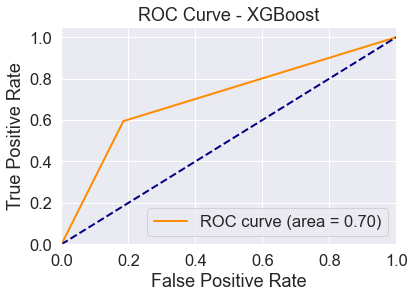

In [115]:
# Compute ROC curve and AUC 
fpr, tpr, thresholds = roc_curve(placed_y_test, 
                                 placed_best.predict(placed_X_test))
calc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         lw = 2, label='ROC curve (area = %0.2f)' % calc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc="lower right")
plt.show()

### XGBoost Model Results and Analysis
The XGBoost Model performs well but not as well as simple logistic regression model that I ran prior. They yield similar results but the logistic regression model is slightly a better model. 

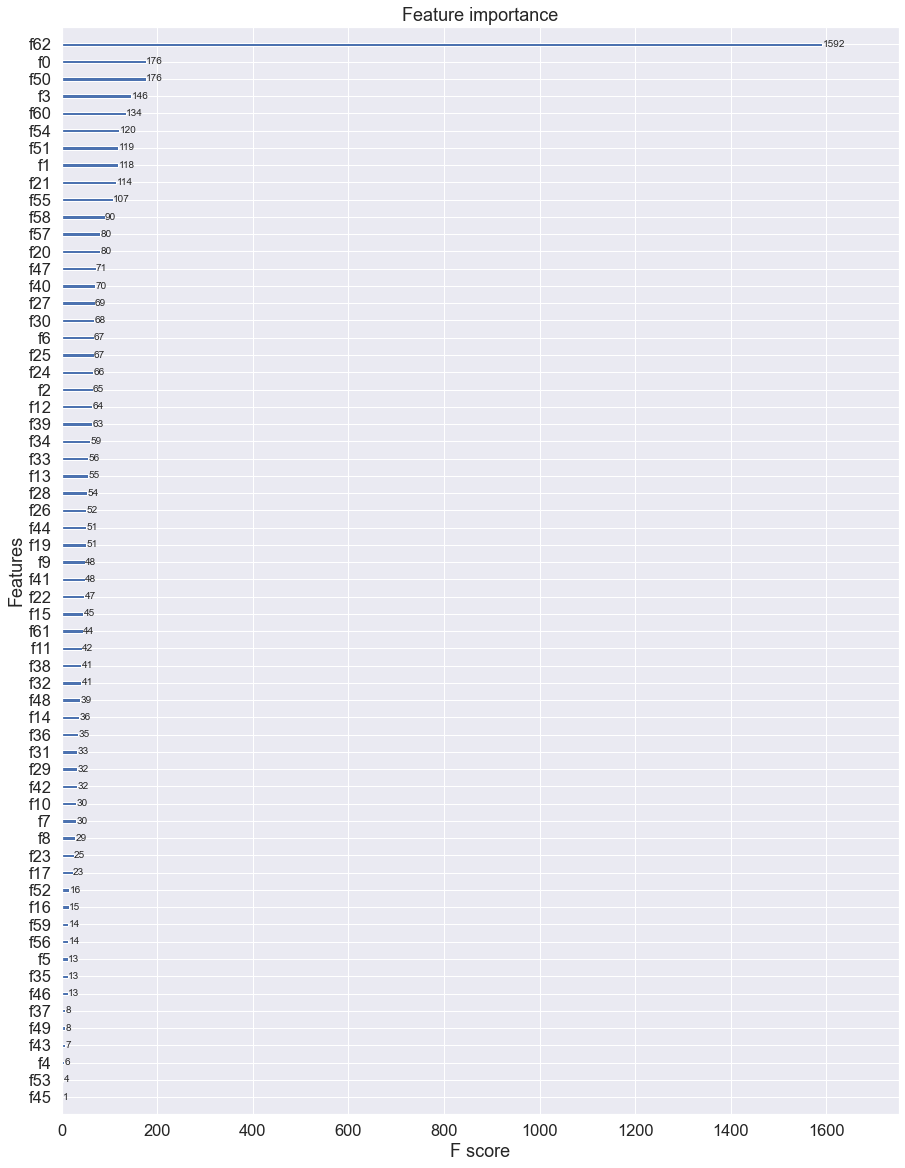

In [117]:
f, ax = plt.subplots(figsize=(15,20))
xgb.plot_importance(placed_best, ax = ax)
plt.show()

In [120]:
# What are the some of the most important features?
print(df[placed_features].columns[62])
print(df[placed_features].columns[0])
print(df[placed_features].columns[50])
print(df[placed_features].columns[3])
print(df[placed_features].columns[60])
print(df[placed_features].columns[54])
print(df[placed_features].columns[51])
print(df[placed_features].columns[1])
print(df[placed_features].columns[21])
print(df[placed_features].columns[55])
print(df[placed_features].columns[58])

log_days
SWE
Male
Data
South Asian or Indian American
Non-Hispanic White or Euro-American
Female
PSO
JAN19A
East Asian or Asian American
Latino or Hispanic American


### Important features for placement modeling
* The log_days(days a fellow is in the program) turned out to be the most important feature in predicting placement, but I honestly figured that it would have a significant impact on placement.

* Another one that caught my attention was SWE was the second most important feature in placement. Pathrise seems to be the best a placing SWE compared to others. 

* The gender of the fellow as well as the fellows' ethnicity had a significant impact on placement.  

# Predicting Days Until Placement

### We are going to start with a simple linear regression

In [135]:
kf = KFold(n_splits = n_folds, shuffle = True, random_state = 42)

train_mses = []
val_mses = []
placement_time_lreg = LinearRegression()

# Perform K-Fold CV
for train_inds, val_inds in kf.split(placement_time_X_train_val):
    X_train, X_val = placement_time_X_train_val[train_inds], placement_time_X_train_val[val_inds]
    y_train, y_val = placement_time_y_train_val[train_inds], placement_time_y_train_val[val_inds]
    
    placement_time_lreg.fit(X_train, y_train)
    train_preds = placement_time_lreg.predict(X_train)
    val_preds = placement_time_lreg.predict(X_val)
    
    train_mses.append(mean_squared_error(y_train, train_preds))
    val_mses.append(mean_squared_error(y_val, val_preds))

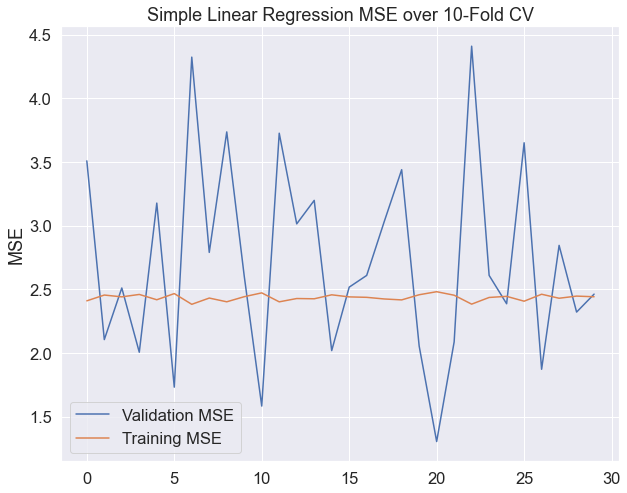

In [136]:
f, ax = plt.subplots(figsize=(10,8))
plt.plot(np.arange(0, n_folds), val_mses, label = 'Validation MSE')
plt.plot(np.arange(0, n_folds), train_mses, label = 'Training MSE')
plt.ylabel('MSE')
plt.title('Simple Linear Regression MSE over 10-Fold CV')
plt.legend()
plt.show()

In [137]:
print('Best Validation MSE:', val_mses[np.argmax(val_mses)])

Best Validation MSE: 4.408599633106714


In [138]:
print('MSE on Test Set: %.4f' % mean_squared_error(placement_time_lreg.predict(placement_time_X_test), placement_time_y_test))

MSE on Test Set: 2.6264


### XGBoost on Days Until Placement 

In [129]:
xgb_fit_dict = {
    'eval_metric': 'rmse',
    "early_stopping_rounds": 15,
    "eval_set": [(placement_time_X_test, placement_time_y_test)],
    'verbose': 100
}

xgb_param_dict = {
    'n_estimators': np.arange(10, 100, 10),
    'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'learning_rate': [0.05, 0.1, 0.3],
    'subsample': stats.uniform(loc=0.2, scale=0.8),
    'colsample_bytree': stats.uniform(loc=0.4, scale=0.6),
    'gamma': [0.0, 0.1, 0.2],
    'max_depth': [5, 7, 10],
    'min_child_samples': stats.randint(100, 500), 
    "objective": ["reg:squarederror"],
    'alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
    'lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
}

placement_time_xgb_model = XGBRegressor(seed = 42, metric = 'None', n_jobs = 4, silent = True)

rs_clf = RandomizedSearchCV(placement_time_xgb_model, random_state = 42, 
                            param_distributions = xgb_param_dict, 
                            n_iter = 50, 
                            cv = n_folds, 
                            scoring = 'neg_mean_squared_error', 
                            verbose = False) 

In [130]:
placement_saved_model = 'placement_best_model.pickle.dat'

if path.exists(placement_saved_model):
    print('I already have a saved model.')
    
    # Load in saved model
    placement_best_model = pickle.load(open(placement_saved_model, 'rb'))
    
    print('Saved Model Parameters')
    print(placement_best_model.get_xgb_params())
    
    # Compute saved model's MSE for test set
    best_xgb_preds = placement_best_model.predict(placement_time_X_test)
    start = time.time()
    print("Model took %.2f seconds to complete." % (time.time()-start))
    print("MSE on Test Set: %.4f" % mean_squared_error(placement_time_y_test, best_xgb_preds))
    
else:
    print('Starting to train...')
    
    # Fit via RandomizedSearch
    start = time.time()
    rs_clf.fit(placement_time_X_train_val, placement_time_y_train_val, **xgb_fit_dict)
    print("RandomizedSearch took %.2f seconds to complete." % (time.time()-start))
    
    # Get best params
    xgb_best_params = rs_clf.best_params_
    
    # Train using best params
    placement_best_model = XGBRegressor(**xgb_best_params, seed = 42)
    start = time.time()
    placement_best_model.fit(placement_time_X_train_val, placement_time_y_train_val)
    
    # Get MSE
    best_xgb_preds = placement_best_model.predict(placement_time_X_test)
    print("Model took %.2f seconds to complete." % (time.time()-start))
    print("MSE on Test Set: %.4f" % mean_squared_error(placement_time_y_test, best_xgb_preds))
    
    # Save best xgb model
    pickle.dump(placement_best_model, open(placement_saved_model, 'wb'))


Starting to train...
[13:13:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.88011
Will train until validation_0-rmse hasn't improved in 15 rounds.
[69]	validation_0-rmse:1.65399
[13:13:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.88148

Will train until validation_0-rmse hasn't improved in 15 rounds.
[69]	validation_0-rmse:1.64912
[13:13:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.88159
Will train until validation_0-rmse hasn't improved in 15 rounds.
[69]	validation_0-rmse:1.63454
[13:13:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[19]	validation_0-rmse:2.29513
[13:13:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.89206
Will train until validation_0-rmse hasn't improved in 15 rounds.
[19]	validation_0-rmse:2.28880
[13:13:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

[0]	validation_0-rmse:3.89425
Will train until validation_0-rmse hasn't improved in 15 rounds.
[19]	validation_0-rmse:2.27469
[13:13:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.89570
Will train until validation_0-rmse hasn't improved in 15 rounds.
[19]	validation_0-rmse:2.27864
[13:13:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip t

[13:13:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.87912
Will train until validation_0-rmse hasn't improved in 15 rounds.
[69]	validation_0-rmse:1.67332
[13:13:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.87877
Will train until val

Will train until validation_0-rmse hasn't improved in 15 rounds.
[69]	validation_0-rmse:1.66018
[13:13:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.87868
Will train until validation_0-rmse hasn't improved in 15 rounds.
[69]	validation_0-rmse:1.66656
[13:13:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[39]	validation_0-rmse:1.81553
[13:13:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.88720
Will train until validation_0-rmse hasn't improved in 15 rounds.
[39]	validation_0-rmse:1.81945
[13:13:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[39]	validation_0-rmse:1.81758
[13:13:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.88788
Will train until validation_0-rmse hasn't improved in 15 rounds.
[39]	validation_0-rmse:1.82470
[13:13:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

[0]	validation_0-rmse:3.72877
Will train until validation_0-rmse hasn't improved in 15 rounds.
[9]	validation_0-rmse:2.17770
[13:13:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.72903
Will train until validation_0-rmse hasn't improved in 15 rounds.
[9]	validation_0-rmse:2.16969
[13:13:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip thr

[0]	validation_0-rmse:3.73386
Will train until validation_0-rmse hasn't improved in 15 rounds.
[9]	validation_0-rmse:2.18500
[13:13:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.73459
Will train until validation_0-rmse hasn't improved in 15 rounds.
[9]	validation_0-rmse:2.18189
[13:13:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip thr

Will train until validation_0-rmse hasn't improved in 15 rounds.
[19]	validation_0-rmse:1.76790
[13:14:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.73318
Will train until validation_0-rmse hasn't improved in 15 rounds.
[19]	validation_0-rmse:1.77344
[13:14:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[19]	validation_0-rmse:1.77344
[13:14:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.73310
Will train until validation_0-rmse hasn't improved in 15 rounds.
[19]	validation_0-rmse:1.76540
[13:14:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
Stopping. Best iteration:
[24]	validation_0-rmse:1.73389

[13:14:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.15204
Will train until validation_0-rmse hasn't improved in 15 rounds.
Stopping. Best iteration:
[36]	validation_0-rmse:1.73289

[13:14:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters

Will train until validation_0-rmse hasn't improved in 15 rounds.
Stopping. Best iteration:
[28]	validation_0-rmse:1.73332

[13:14:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.15587
Will train until validation_0-rmse hasn't improved in 15 rounds.
Stopping. Best iteration:
[28]	validation_0-rmse:1.73303

[13:14:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters

Will train until validation_0-rmse hasn't improved in 15 rounds.
[89]	validation_0-rmse:1.69260
[13:14:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.87371
Will train until validation_0-rmse hasn't improved in 15 rounds.
[89]	validation_0-rmse:1.69783
[13:14:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[89]	validation_0-rmse:1.69926
[13:14:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.87513
Will train until validation_0-rmse hasn't improved in 15 rounds.
[89]	validation_0-rmse:1.70361
[13:14:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[29]	validation_0-rmse:1.65417
[13:14:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.12372
Will train until validation_0-rmse hasn't improved in 15 rounds.
[29]	validation_0-rmse:1.66292
[13:14:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[29]	validation_0-rmse:1.63932
[13:14:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.13215
Will train until validation_0-rmse hasn't improved in 15 rounds.
[29]	validation_0-rmse:1.64422
[13:14:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

[0]	validation_0-rmse:3.11612
Will train until validation_0-rmse hasn't improved in 15 rounds.
[9]	validation_0-rmse:1.64724
[13:14:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.11290
Will train until validation_0-rmse hasn't improved in 15 rounds.
[9]	validation_0-rmse:1.62635
[13:14:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip thr

[0]	validation_0-rmse:3.17342
Will train until validation_0-rmse hasn't improved in 15 rounds.
[9]	validation_0-rmse:1.66102
[13:14:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.72273
Will train until validation_0-rmse hasn't improved in 15 rounds.
[29]	validation_0-rmse:1.64932
[13:14:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip th

[13:14:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.72025
Will train until validation_0-rmse hasn't improved in 15 rounds.
[29]	validation_0-rmse:1.64295
[13:14:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.73406
Will train until val

Will train until validation_0-rmse hasn't improved in 15 rounds.
[29]	validation_0-rmse:1.73361
[13:14:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.25705
Will train until validation_0-rmse hasn't improved in 15 rounds.
[29]	validation_0-rmse:1.73255
[13:14:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

[0]	validation_0-rmse:3.25856
Will train until validation_0-rmse hasn't improved in 15 rounds.
[29]	validation_0-rmse:1.73487
[13:14:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.26797
Will train until validation_0-rmse hasn't improved in 15 rounds.
[29]	validation_0-rmse:1.73449
[13:14:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip t

[13:14:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.77515
Will train until validation_0-rmse hasn't improved in 15 rounds.
[69]	validation_0-rmse:1.64817
[13:14:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.77701
Will train until val

Will train until validation_0-rmse hasn't improved in 15 rounds.
[69]	validation_0-rmse:1.63416
[13:14:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.77732
Will train until validation_0-rmse hasn't improved in 15 rounds.
[69]	validation_0-rmse:1.62624
[13:14:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[69]	validation_0-rmse:1.65657
[13:14:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.72125
Will train until validation_0-rmse hasn't improved in 15 rounds.
[69]	validation_0-rmse:1.64739
[13:14:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[69]	validation_0-rmse:1.64678
[13:14:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.72062
Will train until validation_0-rmse hasn't improved in 15 rounds.
[69]	validation_0-rmse:1.65342
[13:14:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Stopping. Best iteration:
[23]	validation_0-rmse:1.63725

[13:14:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.11856
Will train until validation_0-rmse hasn't improved in 15 rounds.
Stopping. Best iteration:
[15]	validation_0-rmse:1.62872

[13:14:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open a

Will train until validation_0-rmse hasn't improved in 15 rounds.
Stopping. Best iteration:
[28]	validation_0-rmse:1.64227

[13:14:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.12759
Will train until validation_0-rmse hasn't improved in 15 rounds.
Stopping. Best iteration:
[10]	validation_0-rmse:1.64386

[13:14:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters

Will train until validation_0-rmse hasn't improved in 15 rounds.
[59]	validation_0-rmse:1.75448
[13:14:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.88594
Will train until validation_0-rmse hasn't improved in 15 rounds.
[59]	validation_0-rmse:1.75554
[13:14:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[59]	validation_0-rmse:1.75534
[13:14:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.88741
Will train until validation_0-rmse hasn't improved in 15 rounds.
[59]	validation_0-rmse:1.75761
[13:14:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[19]	validation_0-rmse:2.24890
[13:15:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.88314
Will train until validation_0-rmse hasn't improved in 15 rounds.
[19]	validation_0-rmse:2.25021
[13:15:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[19]	validation_0-rmse:2.24935
[13:15:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.88390
Will train until validation_0-rmse hasn't improved in 15 rounds.
[19]	validation_0-rmse:2.24417
[13:15:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[69]	validation_0-rmse:1.67255
[13:15:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.87715
Will train until validation_0-rmse hasn't improved in 15 rounds.
[69]	validation_0-rmse:1.66673
[13:15:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[69]	validation_0-rmse:1.66147
[13:15:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.88100
Will train until validation_0-rmse hasn't improved in 15 rounds.
[69]	validation_0-rmse:1.65561
[13:15:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[69]	validation_0-rmse:1.67402
[13:15:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.87571
Will train until validation_0-rmse hasn't improved in 15 rounds.
[69]	validation_0-rmse:1.68035
[13:15:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[69]	validation_0-rmse:1.67914
[13:15:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.87648
Will train until validation_0-rmse hasn't improved in 15 rounds.
[69]	validation_0-rmse:1.66749
[13:15:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[9]	validation_0-rmse:2.90368
[13:15:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.89231
Will train until validation_0-rmse hasn't improved in 15 rounds.
[9]	validation_0-rmse:2.91028
[13:15:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Plea

[0]	validation_0-rmse:3.89468
Will train until validation_0-rmse hasn't improved in 15 rounds.
[9]	validation_0-rmse:2.88887
[13:15:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.89531
Will train until validation_0-rmse hasn't improved in 15 rounds.
[9]	validation_0-rmse:2.89289
[13:15:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip thr

Will train until validation_0-rmse hasn't improved in 15 rounds.
Stopping. Best iteration:
[10]	validation_0-rmse:1.63566

[13:15:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.11735
Will train until validation_0-rmse hasn't improved in 15 rounds.
Stopping. Best iteration:
[10]	validation_0-rmse:1.62585

[13:15:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters

Will train until validation_0-rmse hasn't improved in 15 rounds.
Stopping. Best iteration:
[10]	validation_0-rmse:1.63589

[13:15:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.13788
Will train until validation_0-rmse hasn't improved in 15 rounds.
Stopping. Best iteration:
[12]	validation_0-rmse:1.62626

[13:15:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters

Will train until validation_0-rmse hasn't improved in 15 rounds.
Stopping. Best iteration:
[44]	validation_0-rmse:1.62164

[13:15:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.31823
Will train until validation_0-rmse hasn't improved in 15 rounds.
Stopping. Best iteration:
[44]	validation_0-rmse:1.61172

[13:15:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters


[0]	validation_0-rmse:3.33394
Will train until validation_0-rmse hasn't improved in 15 rounds.
Stopping. Best iteration:
[71]	validation_0-rmse:1.62314

[13:15:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.33021
Will train until validation_0-rmse hasn't improved in 15 rounds.
Stopping. Best iteration:
[73]	validation_0-rmse:1.62431

[13:15:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XG

[13:15:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.11736
Will train until validation_0-rmse hasn't improved in 15 rounds.
Stopping. Best iteration:
[22]	validation_0-rmse:1.73399

[13:15:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3

Will train until validation_0-rmse hasn't improved in 15 rounds.
[39]	validation_0-rmse:1.73255
[13:15:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.12965
Will train until validation_0-rmse hasn't improved in 15 rounds.
[39]	validation_0-rmse:1.73286
[13:15:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[89]	validation_0-rmse:1.72777
[13:15:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.87693
Will train until validation_0-rmse hasn't improved in 15 rounds.
[89]	validation_0-rmse:1.72664
[13:15:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[89]	validation_0-rmse:1.72860
[13:15:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.72081
Will train until validation_0-rmse hasn't improved in 15 rounds.
Stopping. Best iteration:
[51]	validation_0-rmse:1.66139

[13:15:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip thro

Will train until validation_0-rmse hasn't improved in 15 rounds.
[79]	validation_0-rmse:1.64346
[13:15:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.72110
Will train until validation_0-rmse hasn't improved in 15 rounds.
[79]	validation_0-rmse:1.65644
[13:15:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

[0]	validation_0-rmse:3.72483
Will train until validation_0-rmse hasn't improved in 15 rounds.
Stopping. Best iteration:
[40]	validation_0-rmse:1.65367

[13:15:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.79589
Will train until validation_0-rmse hasn't improved in 15 rounds.
[19]	validation_0-rmse:1.95286
[13:15:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some paramet

[13:15:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.79295
Will train until validation_0-rmse hasn't improved in 15 rounds.
[19]	validation_0-rmse:1.95556
[13:15:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.79425
Will train until val

[0]	validation_0-rmse:3.89719
Will train until validation_0-rmse hasn't improved in 15 rounds.
[9]	validation_0-rmse:2.93021
[13:15:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.89723
Will train until validation_0-rmse hasn't improved in 15 rounds.
[9]	validation_0-rmse:2.92866
[13:15:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip thr

Will train until validation_0-rmse hasn't improved in 15 rounds.
[9]	validation_0-rmse:2.93534
[13:15:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.89815
Will train until validation_0-rmse hasn't improved in 15 rounds.
[9]	validation_0-rmse:2.93175
[13:15:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Plea

Will train until validation_0-rmse hasn't improved in 15 rounds.
[59]	validation_0-rmse:1.66583
[13:15:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.88014
Will train until validation_0-rmse hasn't improved in 15 rounds.
[59]	validation_0-rmse:1.67316
[13:15:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[59]	validation_0-rmse:1.66640
[13:15:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.87943
Will train until validation_0-rmse hasn't improved in 15 rounds.
[59]	validation_0-rmse:1.67250
[13:15:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

[0]	validation_0-rmse:3.13270
Will train until validation_0-rmse hasn't improved in 15 rounds.
[9]	validation_0-rmse:1.62163
[13:15:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.13248
Will train until validation_0-rmse hasn't improved in 15 rounds.
[9]	validation_0-rmse:1.62031
[13:15:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip thr

Will train until validation_0-rmse hasn't improved in 15 rounds.
[9]	validation_0-rmse:1.64223
[13:15:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.15112
Will train until validation_0-rmse hasn't improved in 15 rounds.
[9]	validation_0-rmse:1.63202
[13:15:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Plea

Will train until validation_0-rmse hasn't improved in 15 rounds.
[9]	validation_0-rmse:1.67030
[13:15:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.18138
Will train until validation_0-rmse hasn't improved in 15 rounds.
[9]	validation_0-rmse:1.66688
[13:15:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Plea

Will train until validation_0-rmse hasn't improved in 15 rounds.
[9]	validation_0-rmse:1.66843
[13:15:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.17816
Will train until validation_0-rmse hasn't improved in 15 rounds.
[9]	validation_0-rmse:1.66454
[13:15:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Plea

Will train until validation_0-rmse hasn't improved in 15 rounds.
[29]	validation_0-rmse:1.89286
[13:15:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.87809
Will train until validation_0-rmse hasn't improved in 15 rounds.
[29]	validation_0-rmse:1.89696
[13:15:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[29]	validation_0-rmse:1.89535
[13:15:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.87710
Will train until validation_0-rmse hasn't improved in 15 rounds.
[29]	validation_0-rmse:1.89115
[13:15:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[19]	validation_0-rmse:1.64053
[13:16:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.22036
Will train until validation_0-rmse hasn't improved in 15 rounds.
[19]	validation_0-rmse:1.64210
[13:16:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[19]	validation_0-rmse:1.65808
[13:16:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.23067
Will train until validation_0-rmse hasn't improved in 15 rounds.
[19]	validation_0-rmse:1.64641
[13:16:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

[0]	validation_0-rmse:3.77212
Will train until validation_0-rmse hasn't improved in 15 rounds.
[19]	validation_0-rmse:1.88741
[13:16:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.77439
Will train until validation_0-rmse hasn't improved in 15 rounds.
[19]	validation_0-rmse:1.89491
[13:16:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip t

[13:16:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.78064
Will train until validation_0-rmse hasn't improved in 15 rounds.
[19]	validation_0-rmse:1.87612
[13:16:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.78134
Will train until val

Will train until validation_0-rmse hasn't improved in 15 rounds.
Stopping. Best iteration:
[30]	validation_0-rmse:1.72216

[13:16:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.11634
Will train until validation_0-rmse hasn't improved in 15 rounds.
Stopping. Best iteration:
[15]	validation_0-rmse:1.72296

[13:16:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters

Will train until validation_0-rmse hasn't improved in 15 rounds.
Stopping. Best iteration:
[20]	validation_0-rmse:1.72158

[13:16:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.13119
Will train until validation_0-rmse hasn't improved in 15 rounds.
Stopping. Best iteration:
[20]	validation_0-rmse:1.71846

[13:16:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters

[39]	validation_0-rmse:1.67062
[13:16:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.72075
Will train until validation_0-rmse hasn't improved in 15 rounds.
[39]	validation_0-rmse:1.66975
[13:16:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rm

Will train until validation_0-rmse hasn't improved in 15 rounds.
[39]	validation_0-rmse:1.66090
[13:16:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.72458
Will train until validation_0-rmse hasn't improved in 15 rounds.
[39]	validation_0-rmse:1.65964
[13:16:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
Stopping. Best iteration:
[12]	validation_0-rmse:1.67036

[13:16:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.12012
Will train until validation_0-rmse hasn't improved in 15 rounds.
Stopping. Best iteration:
[11]	validation_0-rmse:1.64139

[13:16:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters

Will train until validation_0-rmse hasn't improved in 15 rounds.
Stopping. Best iteration:
[17]	validation_0-rmse:1.69694

[13:16:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.15026
Will train until validation_0-rmse hasn't improved in 15 rounds.
Stopping. Best iteration:
[18]	validation_0-rmse:1.67779

[13:16:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters

[13:16:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.72018
Will train until validation_0-rmse hasn't improved in 15 rounds.
[49]	validation_0-rmse:1.64282
[13:16:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.72067
Will train until val

Will train until validation_0-rmse hasn't improved in 15 rounds.
[49]	validation_0-rmse:1.65053
[13:16:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.76197
Will train until validation_0-rmse hasn't improved in 15 rounds.
[69]	validation_0-rmse:1.65379
[13:16:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

[13:16:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.75801
Will train until validation_0-rmse hasn't improved in 15 rounds.
[69]	validation_0-rmse:1.64017
[13:16:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.76143
Will train until val

Will train until validation_0-rmse hasn't improved in 15 rounds.
[49]	validation_0-rmse:1.75705
[13:16:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.87951
Will train until validation_0-rmse hasn't improved in 15 rounds.
[49]	validation_0-rmse:1.75799
[13:16:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[49]	validation_0-rmse:1.75450
[13:16:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.88135
Will train until validation_0-rmse hasn't improved in 15 rounds.
[49]	validation_0-rmse:1.75255
[13:16:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[59]	validation_0-rmse:1.63498
[13:16:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.71967
Will train until validation_0-rmse hasn't improved in 15 rounds.
[59]	validation_0-rmse:1.63784
[13:16:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[59]	validation_0-rmse:1.62130
[13:16:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.72337
Will train until validation_0-rmse hasn't improved in 15 rounds.
[59]	validation_0-rmse:1.63468
[13:16:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[59]	validation_0-rmse:1.67326
[13:16:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.89472
Will train until validation_0-rmse hasn't improved in 15 rounds.
[59]	validation_0-rmse:1.68052
[13:16:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[59]	validation_0-rmse:1.67678
[13:16:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.89659
Will train until validation_0-rmse hasn't improved in 15 rounds.
[59]	validation_0-rmse:1.67686
[13:16:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

[0]	validation_0-rmse:3.72807
Will train until validation_0-rmse hasn't improved in 15 rounds.
[9]	validation_0-rmse:2.17549
[13:16:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.72821
Will train until validation_0-rmse hasn't improved in 15 rounds.
[9]	validation_0-rmse:2.17551
[13:16:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip thr

Will train until validation_0-rmse hasn't improved in 15 rounds.
[9]	validation_0-rmse:2.18021
[13:16:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.73290
Will train until validation_0-rmse hasn't improved in 15 rounds.
[9]	validation_0-rmse:2.17495
[13:16:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Plea


[0]	validation_0-rmse:3.87765
Will train until validation_0-rmse hasn't improved in 15 rounds.
[49]	validation_0-rmse:1.68631
[13:16:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.87807
Will train until validation_0-rmse hasn't improved in 15 rounds.
[49]	validation_0-rmse:1.68748
[13:16:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip 

[13:16:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.88125
Will train until validation_0-rmse hasn't improved in 15 rounds.
[49]	validation_0-rmse:1.70897
[13:16:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.88275
Will train until val

Will train until validation_0-rmse hasn't improved in 15 rounds.
[9]	validation_0-rmse:1.64208
[13:16:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.11443
Will train until validation_0-rmse hasn't improved in 15 rounds.
[9]	validation_0-rmse:1.65046
[13:16:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Plea

[0]	validation_0-rmse:3.13680
Will train until validation_0-rmse hasn't improved in 15 rounds.
[9]	validation_0-rmse:1.63826
[13:16:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.14002
Will train until validation_0-rmse hasn't improved in 15 rounds.
[9]	validation_0-rmse:1.65108
[13:16:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip thr

Will train until validation_0-rmse hasn't improved in 15 rounds.
[19]	validation_0-rmse:2.20914
[13:16:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.87700
Will train until validation_0-rmse hasn't improved in 15 rounds.
[19]	validation_0-rmse:2.20258
[13:16:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[19]	validation_0-rmse:2.19758
[13:16:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.87985
Will train until validation_0-rmse hasn't improved in 15 rounds.
[19]	validation_0-rmse:2.20098
[13:16:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[79]	validation_0-rmse:1.70747
[13:17:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.87464
Will train until validation_0-rmse hasn't improved in 15 rounds.
[79]	validation_0-rmse:1.68945
[13:17:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
Stopping. Best iteration:
[61]	validation_0-rmse:1.69182

[13:17:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.87480
Will train until validation_0-rmse hasn't improved in 15 rounds.
[79]	validation_0-rmse:1.70047
[13:17:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip thro

[13:17:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.10624
Will train until validation_0-rmse hasn't improved in 15 rounds.
[19]	validation_0-rmse:1.73457
[13:17:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.10225
Will train until val

Will train until validation_0-rmse hasn't improved in 15 rounds.
[19]	validation_0-rmse:1.73332
[13:17:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.87681
Will train until validation_0-rmse hasn't improved in 15 rounds.
[89]	validation_0-rmse:1.63902
[13:17:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[89]	validation_0-rmse:1.63989
[13:17:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.87874
Will train until validation_0-rmse hasn't improved in 15 rounds.
[89]	validation_0-rmse:1.63605
[13:17:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[19]	validation_0-rmse:1.67220
[13:17:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.17242
Will train until validation_0-rmse hasn't improved in 15 rounds.
[19]	validation_0-rmse:1.68291
[13:17:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[19]	validation_0-rmse:1.66417
[13:17:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.17910
Will train until validation_0-rmse hasn't improved in 15 rounds.
[19]	validation_0-rmse:1.65340
[13:17:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[89]	validation_0-rmse:1.74116
[13:17:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.88495
Will train until validation_0-rmse hasn't improved in 15 rounds.
[89]	validation_0-rmse:1.74080
[13:17:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

Will train until validation_0-rmse hasn't improved in 15 rounds.
[89]	validation_0-rmse:1.73740
[13:17:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:3.88549
Will train until validation_0-rmse hasn't improved in 15 rounds.
[89]	validation_0-rmse:1.73717
[13:17:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { metric, min_child_samples, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Pl

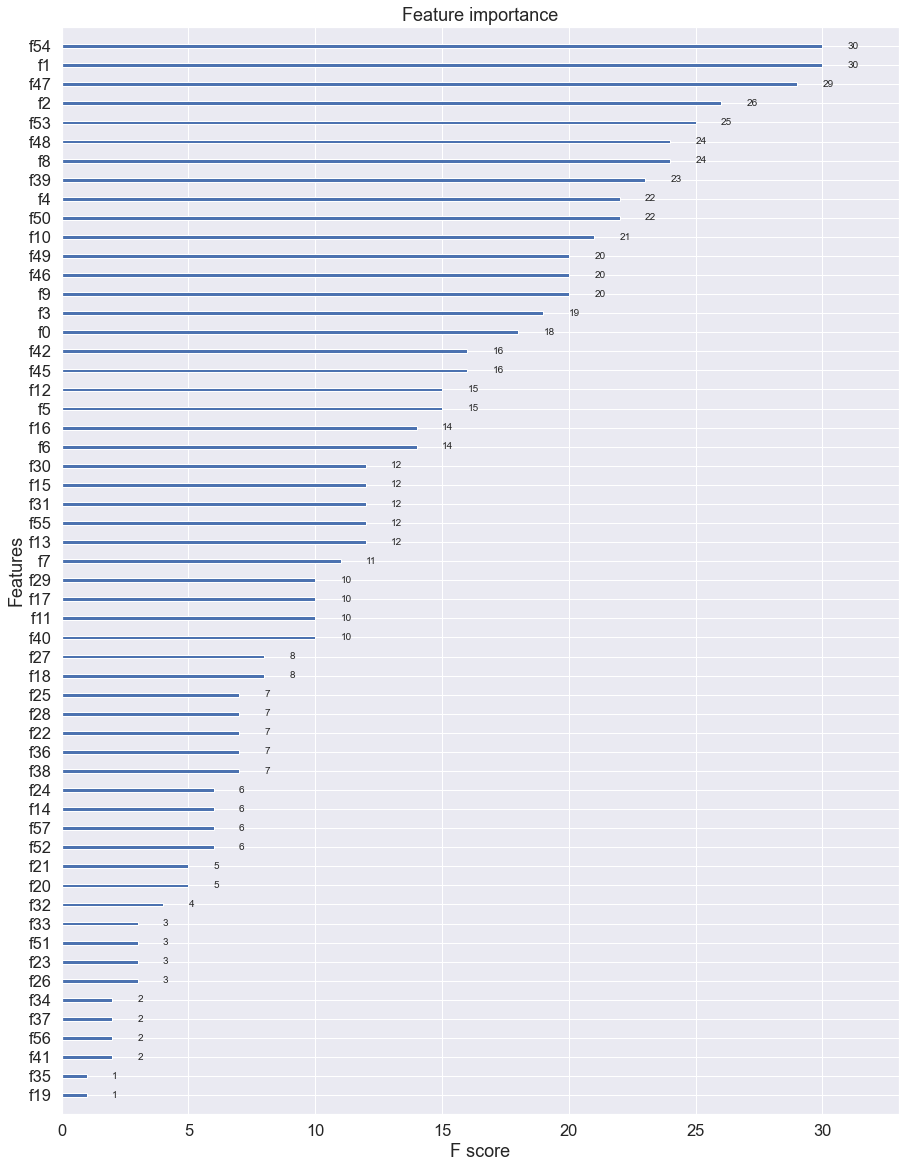

In [132]:
f, ax = plt.subplots(figsize=(15,20))
xgb.plot_importance(placement_best_model, ax = ax)
plt.show()

In [133]:
# What are the some of the most important features?
print(df[placement_time_features].columns[54])
print(df[placement_time_features].columns[1])
print(df[placement_time_features].columns[47])
print(df[placement_time_features].columns[2])
print(df[placement_time_features].columns[53])
print(df[placement_time_features].columns[48])
print(df[placement_time_features].columns[8])
print(df[placement_time_features].columns[39])
print(df[placement_time_features].columns[4])
print(df[placement_time_features].columns[50])

Male
JAN20A
F1 Visa/OPT
AUG19B
H1B
Green Card
NOV19A
SEP19B
SEP19A
Other


### Review of XGBoost Model 
The XGBoost model yielded an MSE of 2.7 MSE, which is the Mean Squared Error -- the difference between predicted and the actual values. The XGBoost regession model showed to be less effective than the linear regression model. 

Both these models do not effectively predict the placement time of the fellows and further research is required to enhance the models or even creating a different model will prove to be worth while. The research did provide some key insights that I will provide below. 

#### Features
The important features comes as a huge surprise to me because placed is not a top feature/significant feature. I would assume that placed would have a more significant impact than Male (gender) which turned out to be the most significant feature. The JAN20A (cohort) is feature that I didn't think matter much but to be fair Janrary is the best time to apply for jobs so it makes sense. Corhort seems to be a top feature as it has a few values that are important to placement time. 

# Conclusion
1. ### Classification model 
      The Classification model yielded the best results. The logistic regression with an AUC of .74 **(XGBoost had an AUC .70)**. Although it is not perfect, it is still deemed as an effective placement classifier. There are still a few things that can be done to further enhance the model, such as implementing a few feature engineering techniques. the insights of the model are provided below.
    * The categorical features with significance for classification model:
        1. primary_track
        2. cohort_tag
        3. gender
        4. race
2. ### Regression Model
The Linear Regression model was not a great one, yielding an MSE of 2.6 and 2.7(XGBoost model). Although the creation of the model did not provide effective predictions on placement time, it still gave us a lot of beneficial insights that could be beneficial for future advancements.
    * The categorical features with significance for Linear Regression Model:
    1. cohort_tag
    2. work_authorization_status
    3. gender


## Key insights of the research

1. * Education did not have a big impact on placement. It did not matter what type of education you had to get placed, getting a less than an HS diploma might've had an impact on being able to enter to program but did not have an impact on placement. The model provided even more evidence that the education did not impact placement, education was not in the top 10 significant features in the model. This allows us to conclude that:
    * Higher education did not mean higher placement rate! 
2. * Many of the fellows had a less than 2 years of experience(many were college students)
3. * Majority of the fellows were legally allowed to work in the United States. 
4. * ON average each fellow sent out an average of 20 applications. 
5. * Many of the fellows who applied to pathrise for were struggling to hear back from recruiters. 
6. * Unemployed and they were Male
7. * ### The median time a fellow stays in the program is around 111 days, that is around the amount that pathrise states. 
8. * ### Sending out many Applications is not correlated with getting placed faster and had a minimal impact on placement.